In [1]:
%load_ext autoreload
%autoreload 2

# IMPORT

In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import colormaps
import numpy as np
import xarray as xr
import scipy
import pandas as pd
import time
from tqdm import tqdm
import seaborn as sns
import os
import json
from matplotlib.colors import Normalize
import itertools
import pingouin as pg
import string

from pycns import CnsStream, CnsReader
import physio
from configuration import *

from tools import *

from multi_projects_jobs import *
from overview_data_pycns import get_patients_list_raw, get_patient_list

from icp_slow_rises_jobs import *

In [5]:
def get_plot_letters(kind = 'upper'):
    if kind == 'upper':
        alphabet = list(string.ascii_uppercase)
    else:
        alphabet = list(string.ascii_lowercase)
    return [f'{letter})' for letter in alphabet]

# Load compliance features for all patients

In [6]:
compliance_all = concat_slow_icp_features('compliance')

P74 not loaded
P65 not loaded
P85 not loaded
P37 not loaded
P75 not loaded
P6 not loaded
P4 not loaded
LD16 not loaded
WJ14 not loaded
P16 not loaded
HA1 not loaded
P41 not loaded
GA9 not loaded


In [7]:
subs_analysis = get_compliance_subs()

In [8]:
len(subs_analysis)

66

# Figure 1 : Graphical view of metrics computations

In [9]:
sub = 'P90'

detections_slow_icp_rises = slow_icp_rise_detection_job.get(sub).to_dataframe()
icp_for_detection = icp_filter_for_detection_job.get(sub)['icp_filter_for_detection']
icp_smoothed = icp_filter_for_trough_filtering_job.get(sub)['icp_filter_for_trough_filtering']

compliance_sub = compliance_all[compliance_all['patient'] == sub].reset_index(drop = True)

reader = CnsReader(data_path / sub)

data_dict = {}
for stream_name, detect_job in zip(['ICP','CO2','ECG_II'],[detect_icp_job, detect_resp_job, detect_ecg_job]):
    stream = reader.streams[stream_name]
    srate = stream.sample_rate
    raw, datetime = stream.get_data(with_times = True, time_as_second = False, apply_gain = True)
    time = stream.get_times(as_second=True)
    detections_events = detect_job.get(sub).to_dataframe()
    data_dict[stream_name] = dict(raw=raw, datetime=datetime, time=time, srate=srate, detections=detections_events)

icp_resp_filtered = iirfilt(data_dict['ICP']['raw'], data_dict['ICP']['srate'], highcut = 0.5)
data_dict['ICP_resp'] = dict(raw=icp_resp_filtered, datetime=data_dict['ICP']['datetime'], time=data_dict['ICP']['time'], srate=data_dict['ICP']['srate'], detections=None)

icp_pulse_resp = interpolate_samples(data_dict['ICP']['detections']['rise_amplitude'].values, 
                                                data_dict['ICP']['detections']['peak_time'].values,
                                                    data_dict['ICP']['time'])
data_dict['ICP_pulse_resp'] = dict(raw=icp_pulse_resp, datetime=data_dict['ICP']['datetime'], time=data_dict['ICP']['time'], srate=data_dict['ICP']['srate'], detections=None)

win_labels_of_detection = compliance_sub[compliance_sub['n_event'] == compliance_sub['n_event'].unique()[-1]].reset_index(drop = True)

win_label_sel = 'rise_2'
dates_win_sel = win_labels_of_detection[win_labels_of_detection['win_label'] == win_label_sel][['start_win_date','stop_win_date']].values[0,:]


resp_cycles = detect_resp_job.get(sub).to_dataframe()
t0 = dates_win_sel[0]
t1 = dates_win_sel[1]

resp_cycles = resp_cycles[(resp_cycles['inspi_date'] > t0) & (resp_cycles['expi_date'] < t1)].reset_index(drop = True)

dict_data_to_deform = {'icp_resp':data_dict['ICP_resp']['raw'], 'icp_pulse':data_dict['ICP_pulse_resp']['raw']}
dict_res_deform = {'icp_resp':None, 'icp_pulse':None}

cycle_times = resp_cycles[['inspi_time','expi_time','next_inspi_time']].values
segment_ratios = 0.4
nbins = 100

for name, data in dict_data_to_deform.items():
    dict_res_deform[name] = physio.deform_traces_to_cycle_template(data = data, 
                                                                times = data_dict['ICP_resp']['time'],
                                                                cycle_times = cycle_times,
                                                                segment_ratios = segment_ratios,
                                                                points_per_cycle = nbins
                                                                )

In [8]:
nrows = 8
figsize = (15, nrows * 5)

dpi = 500
img_extension = '.png'

respi_inspi_span_color = 'm'
respi_expi_span_color = 'b'
alpha_span_resp = 0.1

p_titles = dict(
    fontsize = 25,
    weight = 'bold',
    loc = 'center',
)

x_letter = - 0.07
y_letter = 1.1

p_letter = dict(
    fontsize = 25,
    weight = 'bold',
    ha = 'right',
    va = 'top',
)

p_labels = dict(
    fontsize = 20,
    weight = 'bold',
)

p_ticks = dict(
    fontsize = 15,
    fontweight = 'bold',
)

p_legends = dict(
    fontsize = 15,
    framealpha = 1
)

p_text = dict(
    fontsize = 20,
    weight = 'bold',
)

save_folder = base_folder / 'figures' / 'slow_icp_rises_figs' / 'manuscript_compliance' / 'fig1'

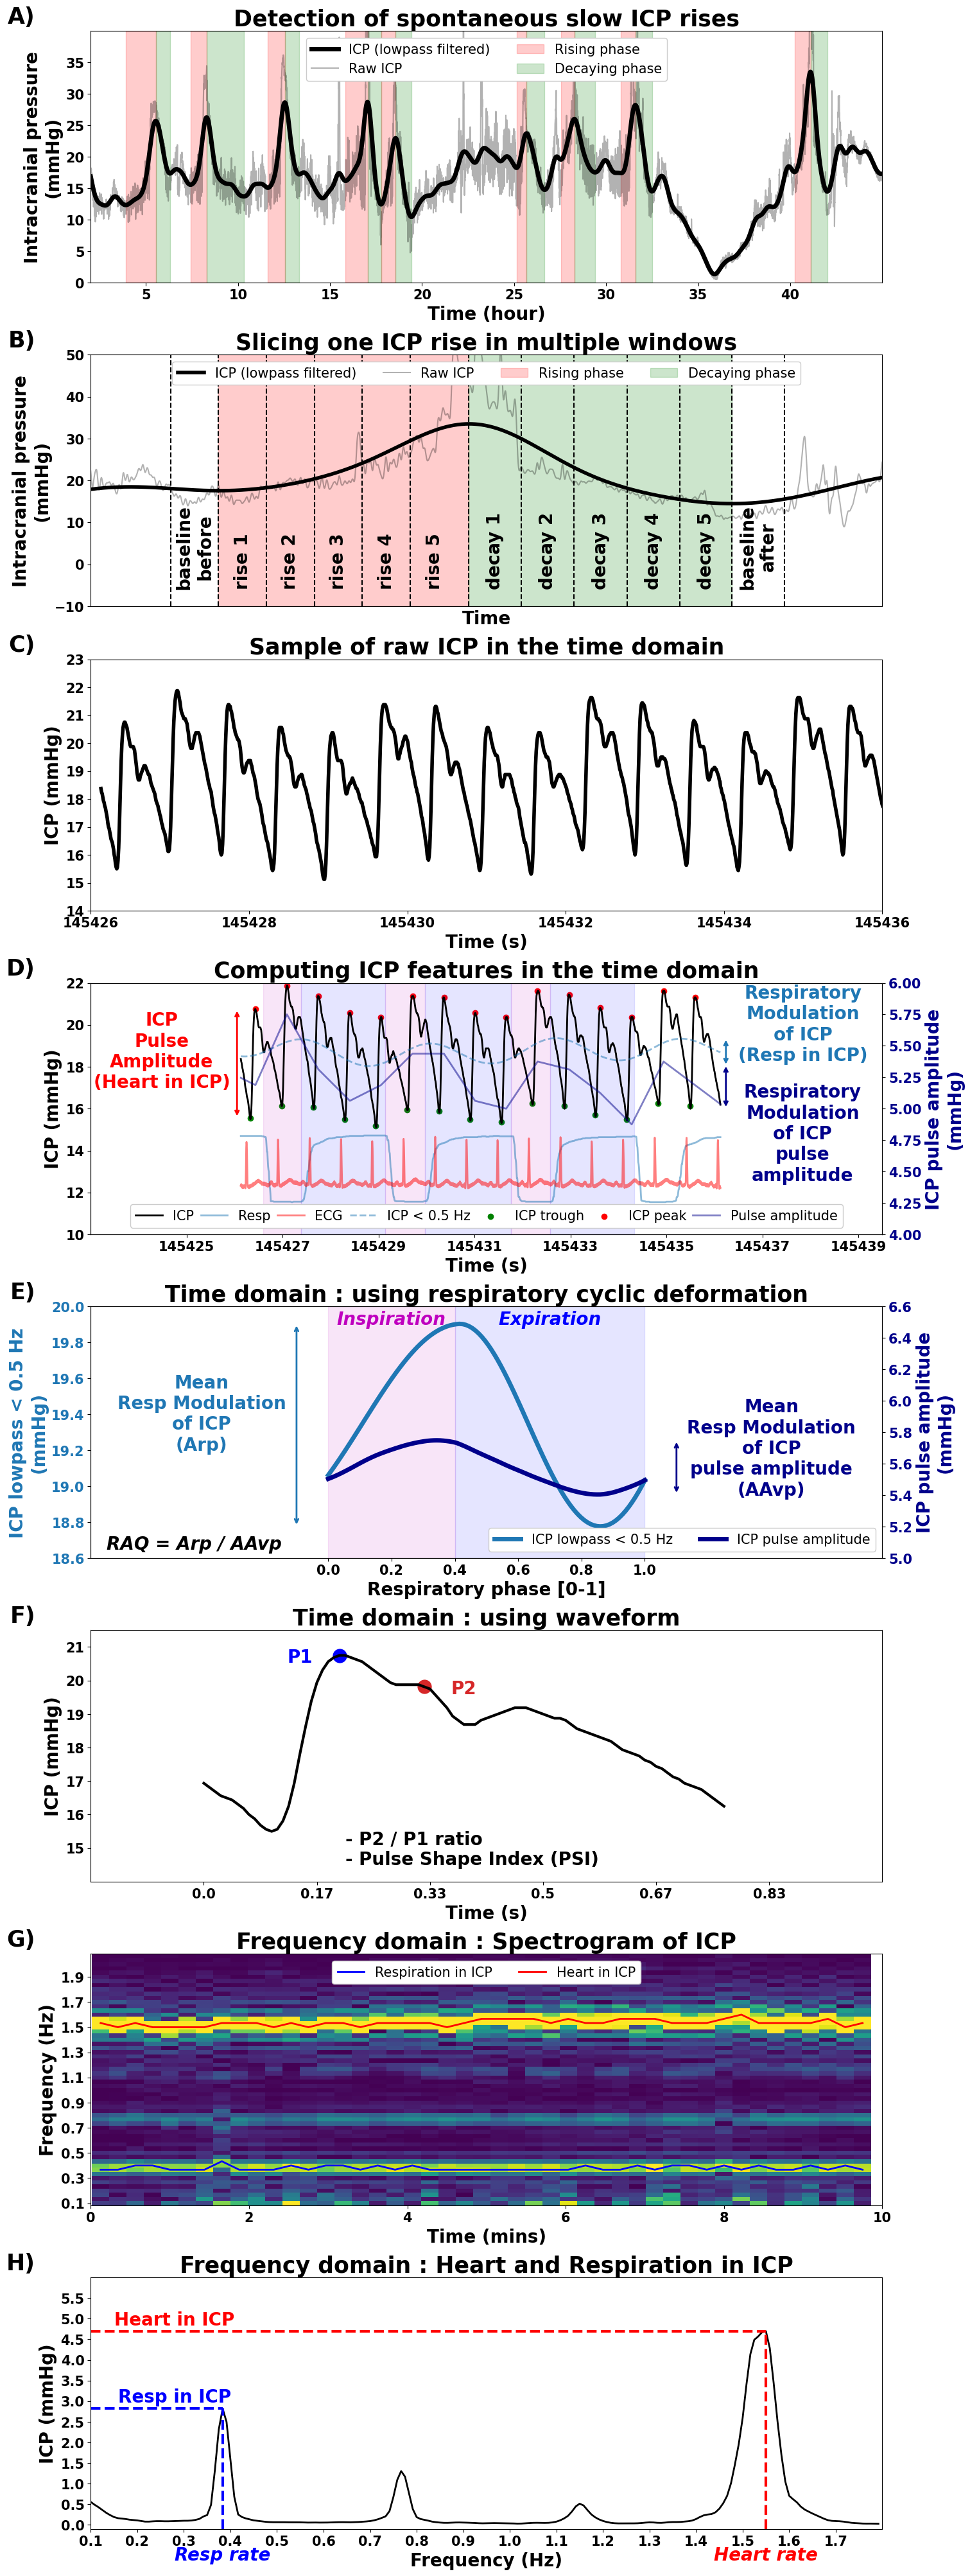

In [9]:
##########
# FIG INIT
##########
fig, axs = plt.subplots(nrows=nrows, figsize = figsize, constrained_layout = True)

##########
# AX0 = A)
##########
ax = axs[0]
letter = 'A'

ax.plot(icp_for_detection.attrs['time'] / 3600, icp_for_detection.values, color = 'k', lw = 5, label = 'ICP (lowpass filtered)')
ax.plot(icp_smoothed.attrs['time'] / 3600, icp_smoothed.values, alpha = 0.3, color = 'k', label = 'Raw ICP')
for i, _ in detections_slow_icp_rises.iterrows():
    if i == detections_slow_icp_rises.shape[0] -1:
        label_rising = 'Rising phase'
        label_decaying = 'Decaying phase'
    else:
        label_rising = None
        label_decaying = None
    ax.axvspan(detections_slow_icp_rises.loc[i, 'trough_time_s'] / 3600, detections_slow_icp_rises.loc[i, 'peak_time_s'] / 3600, color = 'r', alpha = 0.2, label = label_rising)
    ax.axvspan(detections_slow_icp_rises.loc[i, 'peak_time_s'] / 3600, detections_slow_icp_rises.loc[i, 'next_trough_time_s'] / 3600, color = 'g', alpha = 0.2, label = label_decaying)
ax.set_xlim(2, 45)
ax.set_xticks(np.arange(0,50, 5)[1:-1], np.arange(0,50, 5)[1:-1], **p_ticks)
ax.set_xlabel('Time (hour)', **p_labels)

ax.set_ylim(0, 40)
ax.set_yticks(np.arange(0,40, 5), np.arange(0,40, 5), **p_ticks)
ax.set_ylabel('Intracranial pressure\n(mmHg)', **p_labels)

ax.legend(ncols = 2, loc = 'upper center', **p_legends)

ax.text(x_letter, y_letter, f'{letter})', transform=ax.transAxes, **p_letter)
ax.set_title('Detection of spontaneous slow ICP rises', **p_titles)

##########
# AX1 = B)
##########

ax = axs[1]
letter = 'B'

clean_win_labels = {
    'baseline_before':'baseline\nbefore',
    'rise_1':'rise 1',
    'rise_2':'rise 2',
    'rise_3':'rise 3',
    'rise_4':'rise 4',
    'rise_5':'rise 5',
    'decay_1':'decay 1',
    'decay_2':'decay 2',
    'decay_3':'decay 3',
    'decay_4':'decay 4',
    'decay_5':'decay 5',
    'baseline_after':'baseline\nafter',
}

ax.plot(icp_for_detection['datetime'], icp_for_detection.values, color = 'k', lw = 4, label = 'ICP (lowpass filtered)')
ax.plot(icp_smoothed['datetime'], icp_smoothed.values, alpha = 0.3, color = 'k', label = 'Raw ICP')
for i, _ in detections_slow_icp_rises.iterrows():
    if i == detections_slow_icp_rises.shape[0] -1:
        label_rising = 'Rising phase'
        label_decaying = 'Decaying phase'
    else:
        label_rising = None
        label_decaying = None
    ax.axvspan(detections_slow_icp_rises.loc[i, 'trough_date'], detections_slow_icp_rises.loc[i, 'peak_date'], color = 'r', alpha = 0.2, label = label_rising)
    ax.axvspan(detections_slow_icp_rises.loc[i, 'peak_date'], detections_slow_icp_rises.loc[i, 'next_trough_date'], color = 'g', alpha = 0.2, label = label_decaying)
    
    if i == compliance_sub['n_event'].unique()[-1]:
        win_labels_of_detection = compliance_sub[compliance_sub['n_event'] == i].reset_index(drop = True)
        for j, win_row in win_labels_of_detection.iterrows():
            start_d = win_row['start_win_date']
            stop_d = win_row['stop_win_date']
            ax.axvline(start_d, ls = '--', color = 'k')
            if win_row['win_label'] == 'baseline_after':
                ax.axvline(stop_d, ls = '--', color = 'k')
            ax.text(x = stop_d - (stop_d - start_d) / 2,
            y = -5,
            s = clean_win_labels[win_row['win_label']],
            rotation = 90,
            ha = 'center',
            **p_text
            )
ax.set_xlim(np.datetime64('2022-10-19T05:45'), np.datetime64('2022-10-19T08:30'))
ax.set_xticks([])

ax.set_ylim(-10, 45)
ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), **p_ticks)
ax.set_ylabel('Intracranial pressure\n(mmHg)', **p_labels)
ax.set_xlabel('Time', **p_labels)

ax.legend(ncols = 4, loc = 'upper center', **p_legends)

ax.text(x_letter, y_letter, f'{letter})', transform=ax.transAxes, **p_letter)
ax.set_title('Slicing one ICP rise in multiple windows',**p_titles)

##########
# AX2 = C)
##########

ax = axs[2]
letter = 'C'

colors = {'ICP':'k','CO2':'b','ECG_II':'r', 'ICP_resp':'b'}
gains = {'ICP':1, 'CO2':0.2,'ECG_II':4, 'ICP_resp':1}
offsets = {'ICP':0, 'CO2':2,'ECG_II':10, 'ICP_resp':0}
trace_names = {'ICP':'ICP', 'CO2':'CO2\n(respiration)','ECG_II':'ECG', 'ICP_resp':'ICP lowpass < 0.6 Hz'}

t0 = dates_win_sel[0]
t1 = dates_win_sel[0] + np.timedelta64(10, 's')

for stream_name, res in data_dict.items():
    if stream_name == 'ICP':
        local_mask = (res['datetime'] > t0) & (res['datetime'] < t1)
        x = res['time'][local_mask]
        y = res['raw'][local_mask] * gains[stream_name] + offsets[stream_name]
        ax.plot(x, y, color = colors[stream_name], lw = 4, alpha = 1 if stream_name == 'ICP' else 0.5, label = trace_names[stream_name], ls = '--' if stream_name == 'ICP_resp' else None)

ax.ticklabel_format(axis = 'both', style = 'plain', useOffset=False)
ax.set_xlabel('Time (s)', **p_labels)
ax.set_ylabel('ICP (mmHg)', **p_labels)

ax.set_xlim(145426, 145436)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), **p_ticks)
ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), **p_ticks)

ax.text(x_letter, y_letter, f'{letter})', transform=ax.transAxes, **p_letter)
ax.set_title('Sample of raw ICP in the time domain', **p_titles)

##########
# AX3 = D)
##########

ax = axs[3]
letter = 'D'

colors = {'ICP':'k','CO2':'tab:blue','ECG_II':'r', 'ICP_resp':'tab:blue', 'ICP_pulse_resp':'darkblue'}
gains = {'ICP':1, 'CO2':0.1,'ECG_II':2, 'ICP_resp':1, 'ICP_pulse_resp':1}
offsets = {'ICP':0, 'CO2':11.5,'ECG_II':12.5, 'ICP_resp':0, 'ICP_pulse_resp':0}
trace_names = {'ICP':'ICP', 'CO2':'Resp','ECG_II':'ECG', 'ICP_resp':'ICP < 0.5 Hz', 'ICP_pulse_resp':'Pulse amplitude'}
lss =  {'ICP':None, 'CO2':None,'ECG_II':None, 'ICP_resp':'--', 'ICP_pulse_resp':'-'}

t0 = dates_win_sel[0]
t1 = dates_win_sel[0] + np.timedelta64(10, 's')

for stream_name, res in data_dict.items():
    local_mask = (res['datetime'] > t0) & (res['datetime'] < t1)
    x = res['time'][local_mask]
    y = res['raw'][local_mask] * gains[stream_name] + offsets[stream_name]
    if stream_name != 'ICP_pulse_resp':
        ax.plot(x, y, color = colors[stream_name], lw = 2, alpha = 1 if stream_name == 'ICP' else 0.5, label = trace_names[stream_name], ls = lss[stream_name])
    else:
        ax2 = ax.twinx()
        ax2.plot(x, y, color = colors[stream_name], lw = 2, alpha = 1 if stream_name == 'ICP' else 0.5, label = trace_names[stream_name], ls = lss[stream_name])
        
    if stream_name != 'ECG_II':
        detections = res['detections']
        if stream_name == 'ICP':
            local_detections = detections[(detections['trough_date'] > t0) & (detections['peak_date'] < t1)]
            ax.scatter(local_detections['trough_time'], res['raw'][local_detections['trough_ind']], color = 'g', label = 'ICP trough')
            ax.scatter(local_detections['peak_time'], res['raw'][local_detections['peak_ind']], color = 'r', label = 'ICP peak')
            for i, icp_cycle in local_detections.iterrows():
                if i == local_detections.index[0]:
                    # x_pos = icp_cycle['peak_time'] - 1.5
                    x_pos = 145426.05
                    y_start = icp_cycle['amplitude_at_trough']
                    y_end = icp_cycle['amplitude_at_peak']
                    ax.annotate("", xy=(x_pos, y_end), xytext=(x_pos, y_start),arrowprops=dict(arrowstyle="<->", lw=2, color="r", alpha = 1))
                    ax.text(x = x_pos - 1.57, y = 17, s = 'ICP\nPulse\nAmplitude\n(Heart in ICP)', rotation = 0, ha = 'center', color = 'r', weight = 'bold', fontsize = p_text['fontsize'])
        elif stream_name == 'CO2':
            local_detections = detections[(detections['inspi_date'] > t0) & (detections['expi_date'] < t1)]
            for i, cycle in local_detections.iloc[:-1,:].iterrows():
                ax.axvspan(cycle['inspi_time'], cycle['expi_time'], color = respi_inspi_span_color, label = 'inspiration period' if i == local_detections.index[-1] else None, alpha = alpha_span_resp)
                ax.axvspan(cycle['expi_time'], cycle['next_inspi_time'], color = respi_expi_span_color, label = 'expiration period' if i == local_detections.index[-1] else None, alpha = alpha_span_resp)
        elif stream_name == 'ICP_resp':
            # x_pos = x[-1] + 1.5
            x_pos = 145436.24
            y_start = np.min(y)
            y_end = np.max(y)
            ax.annotate("", xy=(x_pos, y_end), xytext=(x_pos, y_start),arrowprops=dict(arrowstyle="<->", lw=2, color=colors[stream_name], alpha = 1))
            ax.text(x = x_pos + 1.61, y = 18.30, s = 'Respiratory\nModulation\nof ICP\n(Resp in ICP)', rotation = 0, ha = 'center', color = colors[stream_name], weight = 'bold', fontsize = p_text['fontsize'])
        elif stream_name == 'ICP_pulse_resp':
            # x_pos = x[-1] + 1.5
            x_pos = 145436.24
            # y_start = np.min(y)
            # y_end = np.max(y)
            y_start = np.quantile(y, 0.05)
            y_end =  np.quantile(y, 0.75)
            ax2.annotate("", xy=(x_pos, y_end), xytext=(x_pos, y_start),arrowprops=dict(arrowstyle="<->", lw=2, color=colors[stream_name], alpha = 1))
            ax2.text(x = x_pos + 1.6, y = 4.8, s = 'Respiratory\nModulation\nof ICP\npulse\namplitude', rotation = 0, ha = 'center', va = 'center', color = colors[stream_name], weight = 'bold', fontsize = p_text['fontsize'])

# ax.set_xlim(x[0] - 1.5, x[-1] + 1.5)
x0 = 145423
x1 = 145439.5
ax.set_xlim(x0, x1)
ax.set_ylim(10, 22)

ax.ticklabel_format(axis = 'both', style = 'plain', useOffset=False)
ax.set_xlabel('Time (s)', **p_labels)
ax.set_ylabel('ICP (mmHg)', **p_labels)

ax.set_xticks(np.arange(x0, x1, 2)[1:], np.arange(x0, x1, 2).astype(int)[1:], **p_ticks)
ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), **p_ticks)

ax2.set_ylim(4,6)
ax2.set_ylabel('ICP pulse amplitude\n(mmHg)', color = colors['ICP_pulse_resp'], **p_labels)
ax2.set_yticks(ax2.get_yticks(), ax2.get_yticklabels(), color = colors['ICP_pulse_resp'], **p_ticks)

ax.text(x_letter, y_letter, f'{letter})', transform=ax.transAxes, **p_letter)
ax.set_title('Computing ICP features in the time domain', **p_titles)

handles = []
labels = []

for axis in [ax, ax2]:
    # Get line plots
    for line in axis.get_lines():
        handles.append(line)
        labels.append(line.get_label())  # Rename dynamically
    
    # Get scatter plots
    for collection in axis.collections:
        handles.append(collection)
        labels.append(collection.get_label())  # Rename dynamically

# Merge legend
ax.legend(handles, labels, loc = 'lower center', ncols = len(handles), columnspacing=0.5, **p_legends)

##########
# AX4 = E)
##########

ax = axs[4]
letter = 'E'

phase = np.linspace(0, 1, nbins)

dict_fig = {'icp_resp':{'color':'tab:blue'},
            'icp_pulse':{'color':'darkblue'},
            }

for name, stack in dict_res_deform.items():
    m = np.mean(stack, axis = 0)
    s = np.std(stack, axis = 0)
    dict_fig[name]['m'] = m
    dict_fig[name]['s'] = s

ax.axvspan(0, 0.4, color = respi_inspi_span_color, alpha = alpha_span_resp, label = 'inspiration')
ax.axvspan(0.4, 1, color = respi_expi_span_color, alpha = alpha_span_resp, label = 'expiration')
ax.set_xlabel('Respiratory phase [0-1]', **p_labels)
ax.set_xlim(-0.75 , 1.75)

name = 'icp_resp'
stack = dict_res_deform[name]
m = np.mean(stack, axis = 0)
s = np.std(stack, axis = 0)
ax.plot(phase, m, color = dict_fig[name]['color'], lw = 5, label = 'ICP lowpass < 0.5 Hz')
# ax.plot(phase, stack.T, color = dict_fig[name]['color'],  lw = 0.2, alpha = 0.2)
ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), color = dict_fig[name]['color'], **p_ticks)
ax.set_ylabel('ICP lowpass < 0.5 Hz\n(mmHg)', color = dict_fig[name]['color'], **p_labels)
x_pos = -0.1
y_start = np.min(m)
y_end = np.max(m)
ax.annotate("", xy=(x_pos, y_end), xytext=(x_pos, y_start),arrowprops=dict(arrowstyle="<->", lw=2, color=dict_fig[name]['color'], alpha = 1))
ax.text(x =-0.4, y = 19.2, s = 'Mean\nResp Modulation\nof ICP\n(Arp)', rotation = 0, ha = 'center', color = dict_fig[name]['color'], weight = 'bold', fontsize = p_text['fontsize'])


ax2 = ax.twinx()
name = 'icp_pulse'
stack = dict_res_deform[name]
m = np.mean(stack, axis = 0)
s = np.std(stack, axis = 0)
ax2.plot(phase, m, color = dict_fig[name]['color'],  lw = 5, label = 'ICP pulse amplitude')
# ax2.plot(phase, stack.T, color = dict_fig[name]['color'],  lw = 0.2, alpha = 0.2)
ax2.set_ylim(5, 6.5)
ax2.set_yticks(ax2.get_yticks(), ax2.get_yticklabels(), color = dict_fig[name]['color'], **p_ticks)
ax2.set_ylabel('ICP pulse amplitude\n(mmHg)', color = dict_fig[name]['color'], **p_labels)
x_pos = 1.1
y_start = np.min(m)
y_end = np.max(m)
ax2.annotate("", xy=(x_pos, y_end), xytext=(x_pos, y_start),arrowprops=dict(arrowstyle="<->", lw=2, color=dict_fig[name]['color'], alpha = 1))
ax2.text(x = 1.4, y = 5.4, s = 'Mean\nResp Modulation\nof ICP\npulse amplitude\n(AAvp)', rotation = 0, ha = 'center', color = dict_fig[name]['color'], weight = 'bold', fontsize = p_text['fontsize'])


handles = []
labels = []

for axis in [ax, ax2]:
    # Get line plots
    for line in axis.get_lines():
        handles.append(line)
        labels.append(line.get_label())  # Rename dynamically
    
    # Get scatter plots
    for collection in axis.collections:
        handles.append(collection)
        labels.append(collection.get_label())  # Rename dynamically

# Merge legend
ax.legend(handles, labels, loc = 'lower right', ncols = len(handles), **p_legends)

ax.text(x = 0.2, y = 19.9, s = 'Inspiration', fontstyle = 'italic', weight = 'bold', color = respi_inspi_span_color, ha = 'center', fontsize = p_text['fontsize'])
ax.text(x = 0.7, y = 19.9, s = 'Expiration', fontstyle = 'italic', weight = 'bold', color = respi_expi_span_color, ha = 'center',fontsize = p_text['fontsize'])
ax.text(x = -0.7, y = 18.65, s = 'RAQ = Arp / AAvp', fontstyle = 'italic', weight = 'bold', color = 'k', fontsize = p_text['fontsize'])

ax.set_xticks(np.arange(0, 1.2, 0.2), np.arange(0, 1.2, 0.2).round(1), **p_ticks)

ax.text(x_letter, y_letter, f'{letter})', transform=ax.transAxes, **p_letter)
ax.set_title('Time domain : using respiratory cyclic deformation', **p_titles)

##########
# AX5 = F)
##########

ax = axs[5]
letter = 'F'

t0 = dates_win_sel[0] + np.timedelta64(100, 'ms')
t1 = dates_win_sel[0] + np.timedelta64(850, 'ms')

stream_name = 'ICP'
res = data_dict[stream_name]
local_mask = (res['datetime'] > t0) & (res['datetime'] < t1)
y = res['raw'][local_mask]
x = np.arange(y.size)
ax.plot(x, y, color = colors[stream_name], lw = 3, alpha = 1 if stream_name == 'ICP' else 0.5, label = trace_names[stream_name], ls = '--' if stream_name == 'ICP_resp' else None)

ax.ticklabel_format(axis = 'both', style = 'plain', useOffset=False)
ax.set_xlabel('Time (s)', **p_labels)
ax.set_ylabel('ICP (mmHg)', **p_labels)

ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), **p_ticks)
ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), **p_ticks)

ax.text(x_letter, y_letter, f'{letter})', transform=ax.transAxes, **p_letter)
ax.set_title('Time domain : using waveform', **p_titles)

x0, x1 = -20, 120
ax.set_xlim(x0, x1)
p1_ind = 24
p2_ind = 39
ax.scatter([x[p1_ind]],[y[p1_ind]], color = 'b', lw=10)
ax.scatter([x[p2_ind]],[y[p2_ind]], color = 'tab:red', lw=10)
ax.text(x = x[p1_ind]- 7, y = y[p1_ind] - 0.2, s = 'P1', color = 'b', weight = 'bold', fontsize=p_text['fontsize'], ha = 'center')
ax.text(x = x[p2_ind]+ 7, y = y[p2_ind] - 0.2, s = 'P2', color = 'tab:red', weight = 'bold', fontsize=p_text['fontsize'], ha = 'center')

ax.text(x = 25, y = 14.5, s = '- P2 / P1 ratio\n- Pulse Shape Index (PSI)', **p_text)
ax.set_ylim(14, 21.5)

ax.set_xticks(ax.get_xticks()[1:], (ax.get_xticks() / 120).round(2)[1:], **p_ticks)

##########
# AX6 = G)
##########

ax = axs[6]
letter = 'G'

t0 = dates_win_sel[0]
t1 = dates_win_sel[1]

res = data_dict['ICP']
mask = (res['datetime'] > t0) & (res['datetime'] < t1)
welch_win_size_s = 15
nperseg = int(welch_win_size_s * res['srate'])
nfft = nperseg * 2

f, t, Sxx = scipy.signal.spectrogram(res['raw'][mask], res['srate'], nperseg = nperseg, nfft = nfft)

ymin = 0.1
ymax = 2.1

mask_f = (f > ymin) & (f < ymax)
q = 0.05
Sxx_masked = np.sqrt(Sxx[mask_f,:])
da = xr.DataArray(data = Sxx_masked, dims = ['freq','time'], coords = {'freq':f[mask_f], 'time':t})
freq_resp = da.loc[0.15:0.6,:].idxmax('freq').values
freq_heart = da.loc[0.8:2.2,:].idxmax('freq').values
max_resp = da.loc[0.15:0.6,:].max('freq').values
max_heart = da.loc[0.8:2.2,:].max('freq').values
vmin = np.quantile(Sxx_masked, q)
vmax = np.quantile(Sxx_masked, 1-q)

ax.pcolormesh(t/60, f[mask_f], Sxx_masked, vmin=vmin, vmax=vmax)
ax.plot(t/60, freq_resp, color = 'b', lw = 2, label = 'Respiration in ICP')
ax.plot(t/60, freq_heart, color = 'r', lw = 2, label = 'Heart in ICP')
ax.set_ylabel('Frequency (Hz)', **p_labels)
ax.set_xlabel('Time (mins)', **p_labels)
ax.legend(loc = 'upper center', ncols = 2, **p_legends)

ax.set_yticks(np.arange(ymin, ymax, 0.1)[::2], np.arange(ymin, ymax, 0.1)[::2].round(2), **p_ticks)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), **p_ticks)

ax.text(x_letter, y_letter, f'{letter})', transform=ax.transAxes, **p_letter)
ax.set_title('Frequency domain : Spectrogram of ICP', **p_titles)

##########
# AX7 = H)
##########

ax = axs[7]
letter = 'H'

t0 = dates_win_sel[0]
t1 = dates_win_sel[1]

res = data_dict['ICP']
mask = (res['datetime'] > t0) & (res['datetime'] < t1)
welch_win_size_s = 60
nperseg = int(welch_win_size_s * res['srate'])
nfft = nperseg * 2
f, power = scipy.signal.welch(res['raw'][mask], res['srate'], nperseg = nperseg, nfft=nfft)
amp = np.sqrt(power)

f_mask = (f > 0.1) & (f < 1.8)

da_amp = xr.DataArray(data = amp[f_mask], dims = ['freq'], coords = {'freq':f[f_mask]})

ylim = (-0.1, 6)
xlim = (0.1, 1.8)

ax.plot(da_amp['freq'], da_amp.values, color = 'k', lw = 2)

d = {
    'resp':dict(band = (0.25, 0.5), name = 'Resp in ICP', color = 'b', xname = 'Resp rate'),
    'heart':dict(band = (1.25, 1.75), name = 'Heart in ICP', color = 'r', xname = 'Heart rate'),
}
for _, res in d.items():
    f0, f1 = res['band']
    fmax = float(da_amp.loc[f0:f1].idxmax())
    vmax = float(da_amp.loc[f0:f1].max())
    ax.vlines(x=fmax, ymin = ylim[0], ymax = vmax, color = res['color'], ls = '--', lw = 3)
    ax.hlines(y=vmax, xmin = xlim[0], xmax = fmax, color = res['color'], ls = '--', lw = 3)
    # ax.text(x = fmax, y = vmax + vmax / 50, s = res['name'], ha = 'center', weight = 'bold', fontsize = 12, color = res['color'])
    ax.text(x = 0.28, y = vmax + 0.15, s = res['name'], ha = 'center', weight = 'bold', fontsize = p_text['fontsize'], color = res['color'])
    ax.text(x = fmax, y = ylim[0] - 0.76, s = res['xname'], ha = 'center', weight = 'bold', fontsize = p_text['fontsize'], color = res['color'], fontstyle = 'italic')

ax.set_ylim(*ylim)
ax.set_xlim(*xlim)

# ax.legend(loc = 'lower center', ncols = 8, framealpha = 1, fontsize = 7)
# ax.ticklabel_format(axis = 'both', style = 'plain', useOffset=False)
ax.set_xlabel('Frequency (Hz)', **p_labels)
ax.set_ylabel('ICP (mmHg)', **p_labels)

ax.set_xticks(np.arange(xlim[0], xlim[-1], 0.1), np.arange(xlim[0], xlim[-1], 0.1).round(2), **p_ticks)
ax.set_yticks(np.arange(0, ylim[-1], 0.5), np.arange(0, ylim[-1], 0.5), **p_ticks)

ax.text(x_letter, y_letter, f'{letter})', transform=ax.transAxes, **p_letter)
ax.set_title('Frequency domain : Heart and Respiration in ICP', **p_titles)

# SAVEFIG
fig.savefig(save_folder / f'fig1_merge{img_extension}', dpi = dpi, bbox_inches = 'tight')
# fig.savefig(save_folder / f'fig1_merge.svg', dpi = dpi, bbox_inches = 'tight')

plt.show()


# Figure 2 : Pointplot of dep_var ~ win_label

In [29]:
mapper_clean_name = {
    "median_icp_mmHg" : "ICP (mmHg)",
    "heart_in_icp_spectrum" : "Heart in ICP\nSpectrum\n(mmHg)",
    "icp_pulse_amplitude_mmHg" : "ICP\nPulse Amplitude\n(mmHg)",
    "resp_in_icp_spectrum" : "Resp in ICP\nSpectrum\n(mmHg)",
    "icp_resp_modulated" : "Resp Modulation\nof ICP\n(mmHg)",
    "ratio_heart_resp_in_icp_spectrum" : "Heart / Resp\nSpectral Ratio",
    "icp_pulse_resp_modulated" : "Resp Modulation of\nICP Pulse Amplitude\n(mmHg)",
    "median_abp_mmHg" : "ABP (mmHg)",
    "median_cpp_mmHg" : "CPP (mmHg)",
    "abp_pulse_amplitude_mmHg" : "ABP\nPulse Amplitude\n(mmHg)",
    "abp_pulse_resp_modulated" : "Resp Modulation of\nABP Pulse Amplitude\n(mmHg)",
    "abp_resp_modulated" : "Resp Modulation\nof ABP\n(mmHg)",
    "RAQ_2" : "RAQ",
    "RAQ_ABP" : "RAQ_ABP",
    "P2P1_ratio" : "P2P1 Ratio",
    "PSI" : "PSI",
    "PRx" : "PRx",
    "heart_rate_bpm" : "Heart Rate (bpm)",
    "resp_rate_cpm" : "Resp Rate (cpm)"
}


In [30]:
def get_relative_variation_to_baseline_res(compliance_all, metrics):
    rows = []
    for p in compliance_all['patient'].unique():
        for e in compliance_all['n_event'].unique():
            df_p_e = compliance_all[(compliance_all['patient'] == p) & (compliance_all['n_event'] == e)].reset_index(drop = True)
            if df_p_e.shape[0] > 0:
                baseline_values = df_p_e.set_index('win_label').loc['baseline_before',metrics].values
                for win in compliance_all['win_label'].unique():
                    win_values = df_p_e.set_index('win_label').loc[win,metrics].values
                    norm_values = ((win_values - baseline_values) / baseline_values) * 100
                    row = {'patient':p, 'n_event':e, 'win_label':win} | {k:v for k,v in zip(metrics,norm_values)}
                    rows.append(row)
    res_norm = pd.DataFrame(rows)
    return res_norm

In [31]:
metrics = ['median_icp_mmHg','median_abp_mmHg','median_cpp_mmHg',
           'heart_in_icp_spectrum','resp_in_icp_spectrum','ratio_heart_resp_in_icp_spectrum',
           'icp_pulse_amplitude_mmHg','icp_resp_modulated','icp_pulse_resp_modulated',
           'abp_pulse_amplitude_mmHg','abp_resp_modulated','abp_pulse_resp_modulated',
           'P2P1_ratio','PSI','PRx',
           'RAQ_2','RAQ_ABP','heart_rate_bpm',
           'resp_rate_cpm'
           ]
res_norm = get_relative_variation_to_baseline_res(compliance_all, metrics)

/tmp/ipykernel_1748972/726534683.py:10: RuntimeWarning: invalid value encountered in scalar divide
  norm_values = ((win_values - baseline_values) / baseline_values) * 100
/tmp/ipykernel_1748972/726534683.py:10: RuntimeWarning: invalid value encountered in scalar divide
  norm_values = ((win_values - baseline_values) / baseline_values) * 100
/tmp/ipykernel_1748972/726534683.py:10: RuntimeWarning: invalid value encountered in scalar divide
  norm_values = ((win_values - baseline_values) / baseline_values) * 100
/tmp/ipykernel_1748972/726534683.py:10: RuntimeWarning: invalid value encountered in scalar divide
  norm_values = ((win_values - baseline_values) / baseline_values) * 100
/tmp/ipykernel_1748972/726534683.py:10: RuntimeWarning: invalid value encountered in scalar divide
  norm_values = ((win_values - baseline_values) / baseline_values) * 100
/tmp/ipykernel_1748972/726534683.py:10: RuntimeWarning: invalid value encountered in scalar divide
  norm_values = ((win_values - baseline_v

In [32]:
lmm_res = pd.read_excel(base_folder / 'figures' / 'slow_icp_rises_figs' / 'res_matrix' / 'results_compliance_lmm.xlsx')

In [33]:
lmm_win_mapper = {v:k for k,v in zip(lmm_res.columns[1:],compliance_all['win_label'].unique())} 
lmm_metric_mapper = {v:k for k,v in zip(lmm_res.iloc[:,0].unique(),metrics)} 

def get_pval_lmm(metric_name, win_label):
    return float(lmm_res.set_index('Metric / Window Label').loc[lmm_metric_mapper[metric_name],lmm_win_mapper[win_label]].split(',')[2][3:])

def get_signifiance_lmm_dict(metric_name):
    signif = {win_label:lmm_res.set_index('Metric / Window Label').loc[lmm_metric_mapper[metric_name],lmm_win_mapper[win_label]].split(',')[3][1:] for win_label in compliance_all['win_label'].unique() if not win_label == 'baseline_before'}
    return signif

def get_inds_signifs(metric_name):
    bool_signif = (pd.Series(get_signifiance_lmm_dict(metric_name)) != 'ns').values
    bool_signif = np.insert(bool_signif, 0, False)
    inds_signif = np.ones(bool_signif.shape)
    inds_signif[~bool_signif] = np.nan
    return inds_signif

In [34]:
dpi = 500
img_extension = '.png'

x_letter = - 0.07
y_letter = 1.1

color_ax2 = 'b'

p_titles = dict(
    fontsize = 25,
    weight = 'bold',
    loc = 'center',
)

p_letter = dict(
    fontsize = 25,
    weight = 'bold',
    ha = 'right',
    va = 'top',
)

p_labels = dict(
    fontsize = 16,
    weight = 'bold',
)

p_ticks = dict(
    fontsize = 15,
    fontweight = 'bold',
)

p_pval_line = dict(
    label = 'p<0.05',
    color = 'darkorange',
    lw = 4,
)


save_folder = base_folder / 'figures' / 'slow_icp_rises_figs' / 'manuscript_compliance' / 'fig2'

In [ ]:
estimator = 'median'
# estimator = 'mean'

# metrics = ['median_icp_mmHg','heart_in_icp_spectrum','icp_pulse_amplitude_mmHg',
#            'resp_in_icp_spectrum','icp_resp_modulated','ratio_heart_resp_in_icp_spectrum', 
#            'icp_pulse_resp_modulated','median_abp_mmHg','median_cpp_mmHg',
#            'abp_pulse_amplitude_mmHg','abp_pulse_resp_modulated','abp_resp_modulated',
#            'RAQ_2','RAQ_ABP','P2P1_ratio', 
#            'PSI','PRx','heart_rate_bpm',
#            'resp_rate_cpm'
#            ]

metrics = ['median_icp_mmHg','median_abp_mmHg','median_cpp_mmHg',
           'heart_in_icp_spectrum','resp_in_icp_spectrum','ratio_heart_resp_in_icp_spectrum',
           'icp_pulse_amplitude_mmHg','icp_resp_modulated','icp_pulse_resp_modulated',
           'abp_pulse_amplitude_mmHg','abp_resp_modulated','abp_pulse_resp_modulated',
           'P2P1_ratio','PSI','PRx',
           'RAQ_2','RAQ_ABP','heart_rate_bpm',
           'resp_rate_cpm'
           ]

letters = get_plot_letters()[:len(metrics)]
d_letters = {m:l for m,l in zip(metrics, letters)}

nrows = 7
ncols = 3
poss = attribute_subplots(metrics, nrows, ncols)

fig, axs = plt.subplots(nrows, ncols, figsize = (ncols * 5,nrows * 3.), constrained_layout = True, sharex = True)
# fig.suptitle(f'Estimator : {estimator}')

for m, (r,c) in poss.items():
        ax = axs[r,c]  

        if m != 'PRx':
                ax2 = ax.twinx()
                sns.pointplot(data = res_norm,
                                x = 'win_label',
                                y = m,
                                ax=ax2,
                                errorbar=('ci',95),
                                estimator=estimator,
                                color = 'b',
                                linestyles="--",
                                )
                ax2.set_ylim(-20, 70)
                ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation = 90, **p_ticks)
                ax2.set_yticks(ax2.get_yticks()[1:-1], ax2.get_yticklabels()[1:-1], rotation = 0, **p_ticks | {'color':color_ax2})
                ax2.set_xlabel('')
                ax2.set_xticks(ax2.get_xticks(), [n.replace('_',' ') for n in compliance_all['win_label'].unique()], **p_ticks)
                ax2.set_ylabel('% vs baseline', **p_labels | {'color':color_ax2})


        sns.pointplot(data = compliance_all,
                        x = 'win_label',
                        y = m,
                        ax=ax,
                        errorbar=('ci',95),
                        estimator=estimator,
                        color = 'k',
                        )
        
        ax.set_yticks(ax.get_yticks()[1:-1], ax.get_yticklabels()[1:-1], rotation = 0, **p_ticks)
        ax.set_xlabel('')
        ax.set_xticks(ax.get_xticks(), [n.replace('_',' ') for n in compliance_all['win_label'].unique()], rotation = 90, **p_ticks)
        ax.set_ylabel(mapper_clean_name[m], **p_labels)
        letter = d_letters[m]
        ax.axvspan(1, 5.5, color = 'r', alpha = 0.2)
        ax.axvspan(5.5, 10, color = 'g', alpha = 0.2)

        ylim = ax.get_ylim()
        y_signif_line = min(ylim) + 0.05 * (max(ylim) - min(ylim))
        ax.plot(np.arange(compliance_all['win_label'].unique().size), get_inds_signifs(m) * y_signif_line, **p_pval_line)

        # ax.text(x_letter, y_letter, letter, transform=ax.transAxes, **p_letter)
        # ax.set_title('Frequency domain : Heart and Respiration in ICP', **p_titles)
        ax.legend(loc = 'upper right', fontsize = 11, framealpha = 0.5)
fig.delaxes(axs[nrows-1, ncols-2])
fig.delaxes(axs[nrows-1, ncols-1])
fig.savefig(save_folder / f'fig2_{estimator}{img_extension}', dpi = dpi, bbox_inches = 'tight')
plt.show()

In [35]:
med_by = compliance_all[['win_label'] + metrics].groupby('win_label').median().loc[compliance_all['win_label'].unique(),:]
med_by

,median_icp_mmHg,median_abp_mmHg,median_cpp_mmHg,heart_in_icp_spectrum,resp_in_icp_spectrum,ratio_heart_resp_in_icp_spectrum,icp_pulse_amplitude_mmHg,icp_resp_modulated,icp_pulse_resp_modulated,abp_pulse_amplitude_mmHg,abp_resp_modulated,abp_pulse_resp_modulated,P2P1_ratio,PSI,PRx,RAQ_2,RAQ_ABP,heart_rate_bpm,resp_rate_cpm
win_label,,,,,,,,,,,,,,,,,,,
baseline_before,14.600747,92.908142,78.445312,10.056105,3.084317,3.332122,6.56250,1.434037,0.800843,76.50000,3.346530,3.674523,1.318322,2.979984,0.052898,1.786023,1.003034,78.808501,19.990005
rise_1,14.579571,93.573361,79.865249,9.697775,3.061532,3.309148,6.34375,1.444746,0.743882,77.37500,3.402145,3.694882,1.316764,2.987356,0.053604,1.805208,1.004513,78.704524,19.990005
rise_2,15.982979,94.242060,79.029272,10.523936,3.163169,3.333865,6.93750,1.486795,0.809155,77.56250,3.374623,3.740720,1.358763,2.989170,0.040369,1.787882,0.997874,78.090091,19.950754
rise_3,18.171838,94.619379,76.654046,11.415554,3.259331,3.559428,7.37500,1.575061,0.894239,79.09375,3.464903,3.844492,1.378672,2.991390,0.081762,1.762276,0.997595,79.120682,19.990005
rise_4,21.215937,95.487524,73.996819,12.606782,3.377961,3.737451,8.53125,1.677092,0.934871,81.50000,3.404944,3.882286,1.428841,2.992222,0.087452,1.714632,0.957817,79.750434,19.990005
rise_5,24.379461,96.128332,70.246742,15.553967,3.883893,3.893182,10.50000,1.836687,1.059069,81.53125,3.500620,4.140376,1.528860,2.996661,0.222387,1.681913,0.915666,80.070873,20.043454
decay_1,24.521559,95.556798,69.795918,18.364779,4.092563,4.071467,10.62500,1.849786,1.055032,80.06250,3.487058,4.336891,1.502441,2.987987,0.205049,1.654305,0.917348,80.177888,20.043454
decay_2,21.482019,94.198141,72.039613,14.745378,3.503661,3.914590,8.93750,1.676142,0.992638,78.84375,3.421270,4.009503,1.406076,2.988341,0.124789,1.679256,0.968623,79.751388,19.990005
decay_3,18.585118,93.056993,73.692438,12.839930,3.301335,3.635843,8.06250,1.573425,0.872051,77.50000,3.429967,3.841849,1.348039,2.974013,0.076071,1.719867,1.021988,79.329507,19.990005


In [36]:
res = []
for win in compliance_all['win_label'].unique():
    d_win = {'win_label':win}
    for metric in metrics:
        d_win[metric] = med_iqr(compliance_all[compliance_all['win_label'] == win][metric], round_=2)
    res.append(d_win)
merge_by = pd.DataFrame(res).set_index('win_label')
# merge_by.to_excel(base_folder / 'figures' / 'slow_icp_rises_figs' / 'manuscript_compliance' / 'med_iqr_res.xlsx')
merge_by

,median_icp_mmHg,median_abp_mmHg,median_cpp_mmHg,heart_in_icp_spectrum,resp_in_icp_spectrum,ratio_heart_resp_in_icp_spectrum,icp_pulse_amplitude_mmHg,icp_resp_modulated,icp_pulse_resp_modulated,abp_pulse_amplitude_mmHg,abp_resp_modulated,abp_pulse_resp_modulated,P2P1_ratio,PSI,PRx,RAQ_2,RAQ_ABP,heart_rate_bpm,resp_rate_cpm
win_label,,,,,,,,,,,,,,,,,,,
baseline_before,"14.6 [11.67, 17.44]","92.91 [85.15, 101.65]","78.45 [71.13, 87.79]","10.06 [6.87, 15.3]","3.08 [2.17, 4.21]","3.33 [2.19, 4.92]","6.56 [4.62, 9.09]","1.43 [1.07, 1.83]","0.8 [0.56, 1.12]","76.5 [64.06, 92.06]","3.35 [2.62, 4.64]","3.67 [2.38, 5.57]","1.32 [0.97, 1.66]","2.98 [2.24, 3.0]","0.05 [-0.15, 0.25]","1.79 [1.43, 2.25]","1.0 [0.74, 1.34]","78.81 [65.58, 90.25]","19.99 [16.98, 22.99]"
rise_1,"14.58 [11.56, 17.42]","93.57 [85.95, 102.66]","79.87 [71.65, 89.23]","9.7 [6.67, 14.69]","3.06 [2.14, 4.12]","3.31 [2.06, 4.92]","6.34 [4.69, 8.81]","1.44 [1.07, 1.8]","0.74 [0.55, 1.12]","77.38 [64.45, 92.22]","3.4 [2.6, 4.76]","3.69 [2.44, 5.36]","1.32 [0.98, 1.66]","2.99 [2.23, 3.0]","0.05 [-0.17, 0.26]","1.81 [1.47, 2.28]","1.0 [0.73, 1.33]","78.7 [65.26, 90.32]","19.99 [16.96, 22.99]"
rise_2,"15.98 [13.04, 18.64]","94.24 [86.82, 103.63]","79.03 [70.51, 87.77]","10.52 [7.01, 15.96]","3.16 [2.2, 4.25]","3.33 [2.15, 5.28]","6.94 [4.94, 9.75]","1.49 [1.11, 1.9]","0.81 [0.56, 1.19]","77.56 [65.64, 92.38]","3.37 [2.62, 4.65]","3.74 [2.47, 5.49]","1.36 [1.02, 1.73]","2.99 [2.38, 3.0]","0.04 [-0.18, 0.29]","1.79 [1.42, 2.25]","1.0 [0.72, 1.31]","78.09 [65.47, 90.25]","19.95 [16.81, 22.99]"
rise_3,"18.17 [15.27, 21.03]","94.62 [86.9, 104.68]","76.65 [69.06, 87.06]","11.42 [7.39, 17.43]","3.26 [2.26, 4.34]","3.56 [2.2, 5.53]","7.38 [5.19, 10.66]","1.58 [1.18, 2.0]","0.89 [0.62, 1.24]","79.09 [65.98, 93.86]","3.46 [2.65, 4.81]","3.84 [2.59, 5.62]","1.38 [1.02, 1.77]","2.99 [2.33, 3.0]","0.08 [-0.15, 0.33]","1.76 [1.41, 2.18]","1.0 [0.7, 1.29]","79.12 [65.37, 90.59]","19.99 [17.0, 22.99]"
rise_4,"21.22 [18.59, 23.89]","95.49 [87.72, 105.66]","74.0 [65.35, 84.62]","12.61 [8.37, 19.3]","3.38 [2.41, 4.55]","3.74 [2.39, 5.55]","8.53 [6.0, 12.25]","1.68 [1.26, 2.09]","0.93 [0.68, 1.33]","81.5 [68.41, 97.31]","3.4 [2.67, 4.8]","3.88 [2.73, 5.71]","1.43 [1.07, 1.86]","2.99 [2.33, 3.0]","0.09 [-0.15, 0.34]","1.71 [1.4, 2.15]","0.96 [0.71, 1.25]","79.75 [65.62, 90.87]","19.99 [17.0, 22.99]"
rise_5,"24.38 [21.51, 27.63]","96.13 [86.78, 106.07]","70.25 [61.07, 80.82]","15.55 [9.99, 24.31]","3.88 [2.7, 5.36]","3.89 [2.43, 6.13]","10.5 [7.03, 14.86]","1.84 [1.44, 2.46]","1.06 [0.68, 1.49]","81.53 [68.45, 99.42]","3.5 [2.7, 4.86]","4.14 [2.93, 6.45]","1.53 [1.15, 1.94]","3.0 [2.46, 3.02]","0.22 [-0.06, 0.47]","1.68 [1.37, 2.08]","0.92 [0.67, 1.18]","80.07 [66.67, 91.6]","20.04 [17.0, 23.07]"
decay_1,"24.52 [21.73, 27.75]","95.56 [86.35, 105.4]","69.8 [61.23, 79.78]","18.36 [11.16, 26.22]","4.09 [2.87, 5.87]","4.07 [2.4, 6.02]","10.62 [7.19, 14.95]","1.85 [1.38, 2.5]","1.06 [0.69, 1.54]","80.06 [68.47, 97.92]","3.49 [2.7, 5.11]","4.34 [2.94, 6.32]","1.5 [1.14, 1.89]","2.99 [2.39, 3.01]","0.21 [-0.04, 0.5]","1.65 [1.35, 1.98]","0.92 [0.66, 1.19]","80.18 [67.77, 91.98]","20.04 [17.04, 23.11]"
decay_2,"21.48 [18.99, 24.45]","94.2 [85.1, 103.27]","72.04 [63.41, 81.91]","14.75 [9.17, 22.55]","3.5 [2.53, 4.85]","3.91 [2.55, 5.86]","8.94 [6.28, 13.47]","1.68 [1.24, 2.16]","0.99 [0.62, 1.42]","78.84 [66.9, 94.89]","3.42 [2.61, 4.87]","4.01 [2.62, 5.92]","1.41 [1.08, 1.78]","2.99 [2.37, 3.0]","0.12 [-0.12, 0.37]","1.68 [1.37, 2.03]","0.97 [0.7, 1.27]","79.75 [66.53, 90.87]","19.99 [16.7, 22.99]"
decay_3,"18.59 [15.63, 21.57]","93.06 [84.53, 102.99]","73.69 [66.79, 84.54]","12.84 [7.96, 19.83]","3.3 [2.37, 4.6]","3.64 [2.34, 5.54]","8.06 [5.44, 11.65]","1.57 [1.14, 2.01]","0.87 [0.59, 1.26]","77.5 [64.59, 92.97]","3.43 [2.64, 4.91]","3.84 [2.63, 5.84]","1.35 [1.03, 1.72]","2.97 [2.3, 3.0]","0.08 [-0.15, 0.37]","1.72 [1.4, 2.18]","1.02 [0.72, 1.32]","79.33 [66.34, 90.32]","19.99 [16.99, 22.99]"


In [37]:
res = []
for win in res_norm['win_label'].unique():
    d_win = {'win_label':win}
    for metric in metrics:
        d_win[metric] = med_iqr(res_norm[res_norm['win_label'] == win][metric], round_=2)
    res.append(d_win)
merge_by_norm = pd.DataFrame(res).set_index('win_label')
# merge_by_norm.to_excel(base_folder / 'figures' / 'slow_icp_rises_figs' / 'manuscript_compliance' / 'med_iqr_res_norm.xlsx')
merge_by_norm

,median_icp_mmHg,median_abp_mmHg,median_cpp_mmHg,heart_in_icp_spectrum,resp_in_icp_spectrum,ratio_heart_resp_in_icp_spectrum,icp_pulse_amplitude_mmHg,icp_resp_modulated,icp_pulse_resp_modulated,abp_pulse_amplitude_mmHg,abp_resp_modulated,abp_pulse_resp_modulated,P2P1_ratio,PSI,PRx,RAQ_2,RAQ_ABP,heart_rate_bpm,resp_rate_cpm
win_label,,,,,,,,,,,,,,,,,,,
baseline_before,"0.0 [0.0, 0.0]","0.0 [0.0, 0.0]","0.0 [0.0, 0.0]","0.0 [0.0, 0.0]","0.0 [0.0, 0.0]","0.0 [0.0, 0.0]","0.0 [0.0, 0.0]","0.0 [0.0, 0.0]","0.0 [0.0, 0.0]","0.0 [0.0, 0.0]","0.0 [0.0, 0.0]","0.0 [0.0, 0.0]","0.0 [0.0, 0.0]","0.0 [0.0, 0.0]","0.0 [0.0, 0.0]","0.0 [0.0, 0.0]","0.0 [0.0, 0.0]","0.0 [0.0, 0.0]","0.0 [0.0, 0.0]"
rise_1,"0.05 [-0.26, 0.24]","0.81 [-0.56, 2.17]","0.99 [-0.67, 2.61]","-2.84 [-10.95, 4.68]","-0.48 [-6.58, 3.84]","-2.67 [-9.27, 7.62]","-0.23 [-5.24, 4.26]","0.09 [-5.95, 5.83]","-0.12 [-7.31, 7.25]","0.38 [-1.89, 2.85]","0.17 [-4.54, 3.8]","-0.26 [-8.78, 6.0]","0.9 [-2.15, 3.91]","0.0 [-0.48, 1.63]","-25.43 [-97.84, 43.59]","0.52 [-4.91, 6.53]","0.5 [-4.72, 6.95]","-0.29 [-1.58, 0.79]","0.0 [-0.12, 0.0]"
rise_2,"8.27 [4.8, 15.2]","1.28 [-1.26, 4.4]","0.02 [-3.41, 3.43]","2.28 [-6.73, 15.51]","2.5 [-4.92, 10.44]","1.29 [-9.73, 12.97]","4.71 [-3.05, 16.0]","3.3 [-3.42, 12.74]","5.0 [-5.1, 16.43]","1.14 [-2.27, 5.51]","0.79 [-5.29, 6.0]","0.77 [-8.61, 10.81]","3.24 [-0.71, 9.21]","0.02 [-0.15, 4.91]","-28.3 [-125.26, 54.35]","-0.16 [-7.42, 8.78]","-0.36 [-7.2, 7.91]","-0.31 [-2.22, 1.44]","0.0 [-0.21, 0.0]"
rise_3,"22.39 [14.07, 38.24]","1.93 [-1.59, 6.25]","-1.92 [-7.02, 2.71]","9.43 [-4.81, 26.58]","4.19 [-4.51, 15.53]","3.45 [-9.11, 17.71]","11.9 [0.49, 28.17]","8.14 [-1.65, 21.06]","9.54 [-2.57, 29.72]","2.74 [-2.56, 8.98]","1.95 [-7.3, 9.09]","2.86 [-8.89, 17.03]","5.48 [-0.31, 13.57]","0.06 [-0.33, 7.41]","-31.83 [-135.76, 52.75]","-0.88 [-12.17, 8.36]","-0.77 [-10.58, 8.73]","-0.26 [-2.66, 2.48]","0.0 [-0.12, 0.2]"
rise_4,"42.86 [27.79, 72.13]","2.42 [-1.57, 7.14]","-5.63 [-11.76, 0.8]","19.99 [-0.34, 46.47]","9.57 [-3.31, 28.85]","7.55 [-10.13, 29.03]","24.93 [4.13, 50.0]","14.43 [2.64, 33.68]","17.05 [-0.51, 52.02]","4.77 [-2.29, 13.5]","1.77 [-7.11, 13.13]","6.16 [-8.37, 25.46]","9.42 [1.5, 19.48]","0.14 [-0.94, 9.53]","-40.67 [-151.51, 53.96]","-3.57 [-16.3, 8.83]","-3.05 [-16.33, 10.63]","0.32 [-2.51, 4.0]","0.0 [-0.19, 0.31]"
rise_5,"65.77 [42.07, 109.87]","2.63 [-2.68, 8.64]","-10.08 [-18.27, -2.14]","44.51 [13.06, 84.05]","20.78 [-0.57, 64.7]","14.86 [-14.9, 48.07]","46.8 [20.34, 85.17]","30.03 [8.5, 67.6]","34.97 [-1.06, 77.33]","6.34 [-1.8, 16.03]","3.14 [-9.26, 23.71]","13.8 [-5.6, 42.93]","16.72 [4.13, 32.87]","0.38 [-1.66, 16.96]","-41.15 [-189.06, 70.9]","-4.28 [-21.66, 11.94]","-7.68 [-23.98, 9.36]","1.25 [-3.44, 7.65]","0.0 [-0.0, 0.53]"
decay_1,"65.16 [41.36, 111.55]","1.86 [-4.14, 8.58]","-10.94 [-19.87, -2.44]","60.8 [24.03, 115.58]","32.34 [2.6, 95.0]","19.02 [-21.05, 58.81]","53.68 [24.07, 98.75]","30.02 [5.23, 76.87]","31.8 [-6.47, 98.46]","4.93 [-3.88, 17.75]","4.5 [-10.25, 27.66]","15.43 [-9.06, 49.38]","14.67 [0.39, 33.93]","0.55 [-2.66, 14.63]","-59.6 [-210.02, 80.51]","-8.13 [-25.74, 11.73]","-7.41 [-26.48, 12.14]","0.9 [-4.83, 9.27]","0.0 [-0.13, 0.56]"
decay_2,"45.97 [27.86, 83.86]","1.87 [-5.25, 7.93]","-7.64 [-16.15, -0.09]","35.49 [6.74, 77.86]","14.66 [-9.77, 50.85]","13.1 [-13.47, 47.86]","33.78 [7.14, 69.66]","14.75 [-3.95, 46.16]","18.46 [-8.87, 65.72]","2.03 [-6.08, 13.5]","2.63 [-11.34, 19.97]","8.42 [-12.65, 37.67]","6.99 [-3.62, 21.49]","0.04 [-1.52, 11.1]","-44.09 [-162.55, 75.08]","-4.51 [-22.62, 11.96]","-5.6 [-21.58, 16.53]","0.71 [-3.33, 7.67]","0.0 [-0.19, 0.29]"
decay_3,"25.94 [10.3, 53.07]","0.85 [-6.19, 7.38]","-4.19 [-12.14, 2.89]","19.32 [-5.02, 52.47]","6.97 [-15.14, 34.37]","9.47 [-15.48, 41.34]","18.96 [-3.19, 47.14]","6.4 [-10.89, 32.16]","8.88 [-18.67, 40.57]","0.92 [-7.85, 12.6]","2.27 [-12.28, 19.24]","4.73 [-14.63, 29.74]","2.74 [-7.16, 15.35]","0.0 [-3.69, 6.26]","-60.12 [-182.49, 

In [16]:
text = f"""As a control, we measured the median ICP level by window, which significantly increased, as described in the previous paragraph. 
Concurrently, the median ABP increased only slightly (from {merge_by.loc['baseline_before','median_abp_mmHg']} to {merge_by.loc['rise_5','median_abp_mmHg']} mmHg, representing a change of +{merge_by_norm.loc['rise_5','median_abp_mmHg']} %), 
likely in an attempt to maintain CPP, which, however, decreased from {merge_by.loc['baseline_before','median_cpp_mmHg']} to {merge_by.loc['decay_1','median_cpp_mmHg']} mmHg ({merge_by_norm.loc['decay_1','median_cpp_mmHg']} %). 
The influence of the heart on ICP increased by {merge_by_norm.loc['decay_1','icp_pulse_amplitude_mmHg']} %, from {merge_by.loc['baseline_before','icp_pulse_amplitude_mmHg']} to {merge_by.loc['decay_1','icp_pulse_amplitude_mmHg']} mmHg (ICP pulse amplitude), 
a finding almost identically observed in the frequency domain (Heart in ICP spectrum). 
The influence of respiration on ICP increased to a lesser extent, by {merge_by_norm.loc['decay_1','icp_resp_modulated']} %, from {merge_by.loc['baseline_before','icp_resp_modulated']} to {merge_by.loc['decay_1','icp_resp_modulated']} mmHg (Respiratory Modulation of ICP), 
with almost identical relative changes observed in the frequency domain (Respiration in ICP spectrum). 
Consequently, the Heart/Respiratory spectral ratio (the ratio of the heart's impact to the respiration's impact in the frequency domain) also increased, 
though to a lesser extent (+{merge_by_norm.loc['decay_1','ratio_heart_resp_in_icp_spectrum']} %). 
The respiratory modulation of ICP pulse amplitude also increased significantly, from {merge_by.loc['baseline_before','icp_pulse_resp_modulated']} to {merge_by.loc['rise_5','icp_pulse_resp_modulated']} mmHg (+{merge_by_norm.loc['rise_5','icp_pulse_resp_modulated']} %).
We explored the dynamics of the same metrics in ABP, as it is closely linked to ICP. Both ABP pulse amplitude and the respiratory modulation of ABP increased,
 though only slightly (from {merge_by.loc['baseline_before','abp_pulse_amplitude_mmHg']} to {merge_by.loc['rise_5','abp_pulse_amplitude_mmHg']} mmHg; +{merge_by_norm.loc['rise_5','abp_pulse_amplitude_mmHg']} % and from {merge_by.loc['baseline_before','abp_resp_modulated']} to {merge_by.loc['rise_5','abp_resp_modulated']} mmHg; +{merge_by_norm.loc['rise_5','abp_resp_modulated']} %, respectively), 
 in the same direction as observed in ICP. Interestingly, respiratory modulation of ABP pulse amplitude increased more than the latter (from {merge_by.loc['baseline_before','abp_pulse_resp_modulated']} to {merge_by.loc['rise_5','abp_pulse_resp_modulated']} mmHg; +{merge_by_norm.loc['rise_5','abp_pulse_resp_modulated']}%), though not significantly. 
Since both ICP and ABP concurrently increased, PRx rose from {merge_by.loc['baseline_before','PRx']} to {merge_by.loc['rise_5','PRx']}. 
This could be interpreted as a disruption of cerebral flow autoregulation; however, we believe it reflects a good adaptation of ABP to ICP to maintain CPP. 
This suggests that PRx may not be interpretable when changes in CPP are due to variations in ICP rather than ABP, a point we will discuss further in the Discussion section. 
The P2/P1 ratio increased from {merge_by.loc['baseline_before','P2P1_ratio']} to {merge_by.loc['rise_5','P2P1_ratio']} (+{merge_by_norm.loc['rise_5','P2P1_ratio']} %), while PSI marginally increased from {merge_by.loc['baseline_before','PSI']} to {merge_by.loc['rise_5','PSI']} (+{merge_by_norm.loc['rise_5','PSI']} %). 
Thus, PSI did not show significant variation, a point that will be discussed further in the Discussion section. RAQ2 showed a slight relative decrease ({merge_by_norm.loc['decay_1','RAQ_2']} %), attributed to a smaller increase in the respiratory modulation of ICP (Arp in the numerator) and a decrease in the respiratory modulation of ICP pulse amplitude (AAvp in the denominator).
 A similar trend was observed for RAQ in ABP.
"""

print(text)

As a control, we measured the median ICP level by window, which significantly increased, as described in the previous paragraph. 
Concurrently, the median ABP increased only slightly (from 92.91 [85.15, 101.65] to 96.13 [86.78, 106.07] mmHg, representing a change of +2.63 [-2.68, 8.64] %), 
likely in an attempt to maintain CPP, which, however, decreased from 78.45 [71.13, 87.79] to 69.8 [61.23, 79.78] mmHg (-10.94 [-19.87, -2.44] %). 
The influence of the heart on ICP increased by 53.68 [24.07, 98.75] %, from 6.56 [4.62, 9.09] to 10.62 [7.19, 14.95] mmHg (ICP pulse amplitude), 
a finding almost identically observed in the frequency domain (Heart in ICP spectrum). 
The influence of respiration on ICP increased to a lesser extent, by 30.02 [5.23, 76.87] %, from 1.43 [1.07, 1.83] to 1.85 [1.38, 2.5] mmHg (Respiratory Modulation of ICP), 
with almost identical relative changes observed in the frequency domain (Respiration in ICP spectrum). 
Consequently, the Heart/Respiratory spectral rati

# Figure 3 : Pairplot

In [10]:
save_folder = base_folder / 'figures' / 'slow_icp_rises_figs' / 'manuscript_compliance' / 'fig3'

In [11]:
data_full = compliance_all.copy()
data_full

,patient,gender,age,stay_duration_days,diagnosis,glasgow_beginning,glasgow_end,mrs_end,fisher,wfns,...,P2P1_ratio,PSI,icp_pulse_amplitude_mmHg,abp_pulse_amplitude_mmHg,PRx,median_icp_mmHg,median_abp_mmHg,median_cpp_mmHg,heart_rate_bpm,resp_rate_cpm
0,P90,M,27.413699,1.911111,TC,3.0,15.0,2.0,NaN,NaN,...,0.764803,1.060423,6.9375,57.5000,0.060989,12.540088,80.550546,68.010458,93.416329,22.047800
1,P90,M,27.413699,1.911111,TC,3.0,15.0,2.0,NaN,NaN,...,0.828945,1.185586,6.1875,57.6875,-0.271599,12.503330,82.863640,70.360310,91.983627,22.047800
2,P90,M,27.413699,1.911111,TC,3.0,15.0,2.0,NaN,NaN,...,0.837838,1.224924,6.2500,56.9375,-0.299044,13.216993,83.292639,70.075646,91.422720,22.047800
3,P90,M,27.413699,1.911111,TC,3.0,15.0,2.0,NaN,NaN,...,0.834242,1.258405,6.2500,57.1250,-0.329268,14.038115,83.225711,69.187596,91.144825,22.047800
4,P90,M,27.413699,1.911111,TC,3.0,15.0,2.0,NaN,NaN,...,0.945273,1.833845,6.3125,58.7500,-0.176923,17.889163,84.352105,66.462943,90.049933,22.047800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6211,P89,F,54.876712,9.809722,HSA,3.0,13.0,3.0,4.0,5.0,...,1.660341,3.012769,8.9375,77.5000,-0.052137,20.047758,93.010414,72.962656,78.090225,15.022549
6212,P89,F,54.876712,9.809722,HSA,3.0,13.0,3.0,4.0,5.0,...,1.726031,3.035160,9.0625,79.8125,0.174626,18.304977,92.595159,74.290182,77.484942,14.992504
6213,P89,F,54.876712,9.809722,HSA,3.0,13.0,3.0,4.0,5.0,...,1.574852,2.753617,6.1875,81.0625,0.151561,16.438175,92.374930,75.936755,76.888871,15.037632
6214,P89,F,54.876712,9.809722,HSA,3.0,13.0,3.0,4.0,5.0,...,1.462219,2.259711,5.0000,79.1250,-0.413676,15.451052,93.249371,77.798319,79.120392,15.052715


In [12]:
def compute_bins(series, nbins = 50, n_mads = 6):
    a = series.values
    max_ = np.nanmax(a)
    min_ = np.nanmin(a)
    name = series.name
    if np.any(np.isnan(a)):
        a = a[~np.isnan(a)]
    med, mad = physio.compute_median_mad(a)
    inf = med - n_mads * mad
    sup = med + n_mads * mad
    if sup > max_:
        sup = max_
    if inf < min_:
        inf = min_
    if name != 'PRx':
        bins = np.linspace(inf if inf > 0 else 0, sup, nbins)
    else:
        bins = np.linspace(inf, sup, nbins)
    return bins

In [13]:
def get_significance(p_value):
    if p_value <= 0.001:
        return "***"
    elif p_value <= 0.01:
        return "**"
    elif p_value <= 0.05:
        return "*"
    else:
        return "ns"

In [14]:

mapper_clean_name = {
    "median_icp_mmHg" : "ICP (mmHg)",
    "heart_in_icp_spectrum" : "Heart\nin ICP Spectrum\n(mmHg)",
    "icp_pulse_amplitude_mmHg" : "ICP\nPulse Amplitude\n(mmHg)",
    "resp_in_icp_spectrum" : "Respiration\nin ICP Spectrum\n(mmHg)",
    "icp_resp_modulated" : "Respiratory\nModulation of ICP\n(mmHg)",
    "ratio_heart_resp_in_icp_spectrum" : "Heart / Resp\nSpectral Ratio",
    "icp_pulse_resp_modulated" : "Respiratory\nModulation of\nICP Pulse Amplitude (mmHg)",
    "median_abp_mmHg" : "ABP (mmHg)",
    "median_cpp_mmHg" : "CPP (mmHg)",
    "abp_pulse_amplitude_mmHg" : "ABP\nPulse Amplitude (mmHg)",
    "abp_pulse_resp_modulated" : "Respiratory\nModulation of\nABP Pulse Amplitude (mmHg)",
    "abp_resp_modulated" : "Respiratory\nModulation\nof ABP (mmHg)",
    "RAQ_2" : "RAQ_2",
    "RAQ_ABP" : "RAQ_ABP",
    "P2P1_ratio" : "P2P1 Ratio",
    "PSI" : "PSI",
    "PRx" : "PRx",
    "heart_rate_bpm" : "Heart Rate (bpm)",
    "resp_rate_cpm" : "Respiratory Rate (cpm)"
}


In [15]:
# data = data_full.iloc[:,45:51]
# full_metrics =  list(mapper_clean_name.keys())[:]
full_metrics = ['median_icp_mmHg','median_abp_mmHg','median_cpp_mmHg',
           'heart_in_icp_spectrum','resp_in_icp_spectrum','ratio_heart_resp_in_icp_spectrum',
           'icp_pulse_amplitude_mmHg','icp_resp_modulated','icp_pulse_resp_modulated',
           'abp_pulse_amplitude_mmHg','abp_resp_modulated','abp_pulse_resp_modulated',
           'P2P1_ratio','PSI','PRx',
           'RAQ_2','RAQ_ABP','heart_rate_bpm',
           'resp_rate_cpm'
           ]
data = data_full.loc[:,full_metrics]
print(data.columns)

Index(['median_icp_mmHg', 'median_abp_mmHg', 'median_cpp_mmHg',
       'heart_in_icp_spectrum', 'resp_in_icp_spectrum',
       'ratio_heart_resp_in_icp_spectrum', 'icp_pulse_amplitude_mmHg',
       'icp_resp_modulated', 'icp_pulse_resp_modulated',
       'abp_pulse_amplitude_mmHg', 'abp_resp_modulated',
       'abp_pulse_resp_modulated', 'P2P1_ratio', 'PSI', 'PRx', 'RAQ_2',
       'RAQ_ABP', 'heart_rate_bpm', 'resp_rate_cpm'],
      dtype='object')


In [16]:
rcorr = pg.rcorr(data, method = 'spearman', padjust='bonf')
rcorr.index = [mapper_clean_name[n].replace('\n',' ') for n in full_metrics]
rcorr.columns = [mapper_clean_name[n].replace('\n',' ') for n in full_metrics]
# rcorr.to_excel(save_folder / 'rcorr.xlsx')

/home/valentin.ghibaudo/.virtualenvs/py3.11_cluster/lib/python3.11/site-packages/pingouin/correlation.py:1116: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mat_upper = mat_upper.applymap(replace_pval)


In [18]:
def pairplot_homemade(data, mapper_clean_name = None, savefile = None, **kwargs):
    p_labels = kwargs.get("p_labels", {})  # Extract p_labels if provided
    p_ticks = kwargs.get("p_ticks", {})  # Extract p_ticks if provided
    metrics = data.columns.tolist()
    if mapper_clean_name is None:
        mapper_clean_name = {k:v for k,v in zip(metrics,metrics)}
    combinations = [i for i in itertools.combinations(metrics, 2)]

    nrows = len(data.columns)
    ncols = nrows

    norm = Normalize(-1, 1)
    cmap = plt.get_cmap('seismic')

    figsize = (nrows * 3, ncols * 3)

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize = figsize, constrained_layout = True)

    is_done = pd.DataFrame(index = data.columns, columns = data.columns, dtype = 'bool')
    is_done[:] = False
    for r in range(nrows):
        for c in range(ncols):
            ax = axs[r,c]
            row_metric = data.columns[r]
            col_metric = data.columns[c]
            if row_metric == col_metric and not is_done.iloc[r,c]:
                bins_x = compute_bins(data[row_metric])
                ax.hist(data[row_metric], bins=bins_x, color = 'k')
                ax.set_xlabel(mapper_clean_name[row_metric], **p_labels)
                ax.set_ylabel('Count', **p_labels)
                ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), **p_ticks)
                ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), **p_ticks)
            else:
                if not is_done.iloc[r,c] and not is_done.iloc[c,r]: 
                    bins_x = compute_bins(data[row_metric])
                    bins_y = compute_bins(data[col_metric])
                    sns.histplot(data = data, x = row_metric, y = col_metric, ax = ax, bins = (bins_x,bins_y), color = 'k', pthresh=0.05, pmax=0.95)
                    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), **p_ticks)
                    ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), **p_ticks)
                else:
                    data_sel = data[[row_metric, col_metric]].dropna()
                    res = scipy.stats.spearmanr(data_sel[row_metric], data_sel[col_metric])
                    r_coef = res.statistic
                    p = res.pvalue * len(combinations)
                    p = 1 if p > 1 else p
                    s = 'R : {r_coef}\np : {p}'.format(r_coef=round(r_coef, 3), p = get_significance(p))
                    ax.text(0.5, 0.5, s, ha = 'center', weight = 'bold', fontsize = 20, va = 'center')
                    ax.set_facecolor(cmap(norm(r_coef)))
                    ax.set_xticks([])
                    ax.set_yticks([])
                ax.set_xlabel(mapper_clean_name[row_metric], **p_labels)
                ax.set_ylabel(mapper_clean_name[col_metric], **p_labels)
            is_done.iloc[r,c] = True
    if not savefile is None:
        fig.savefig(savefile, bbox_inches = 'tight', dpi = 500)
    plt.show()

In [19]:
pairplot_homemade(data, mapper_clean_name, savefile = save_folder / 'full_pairplot.png')

28


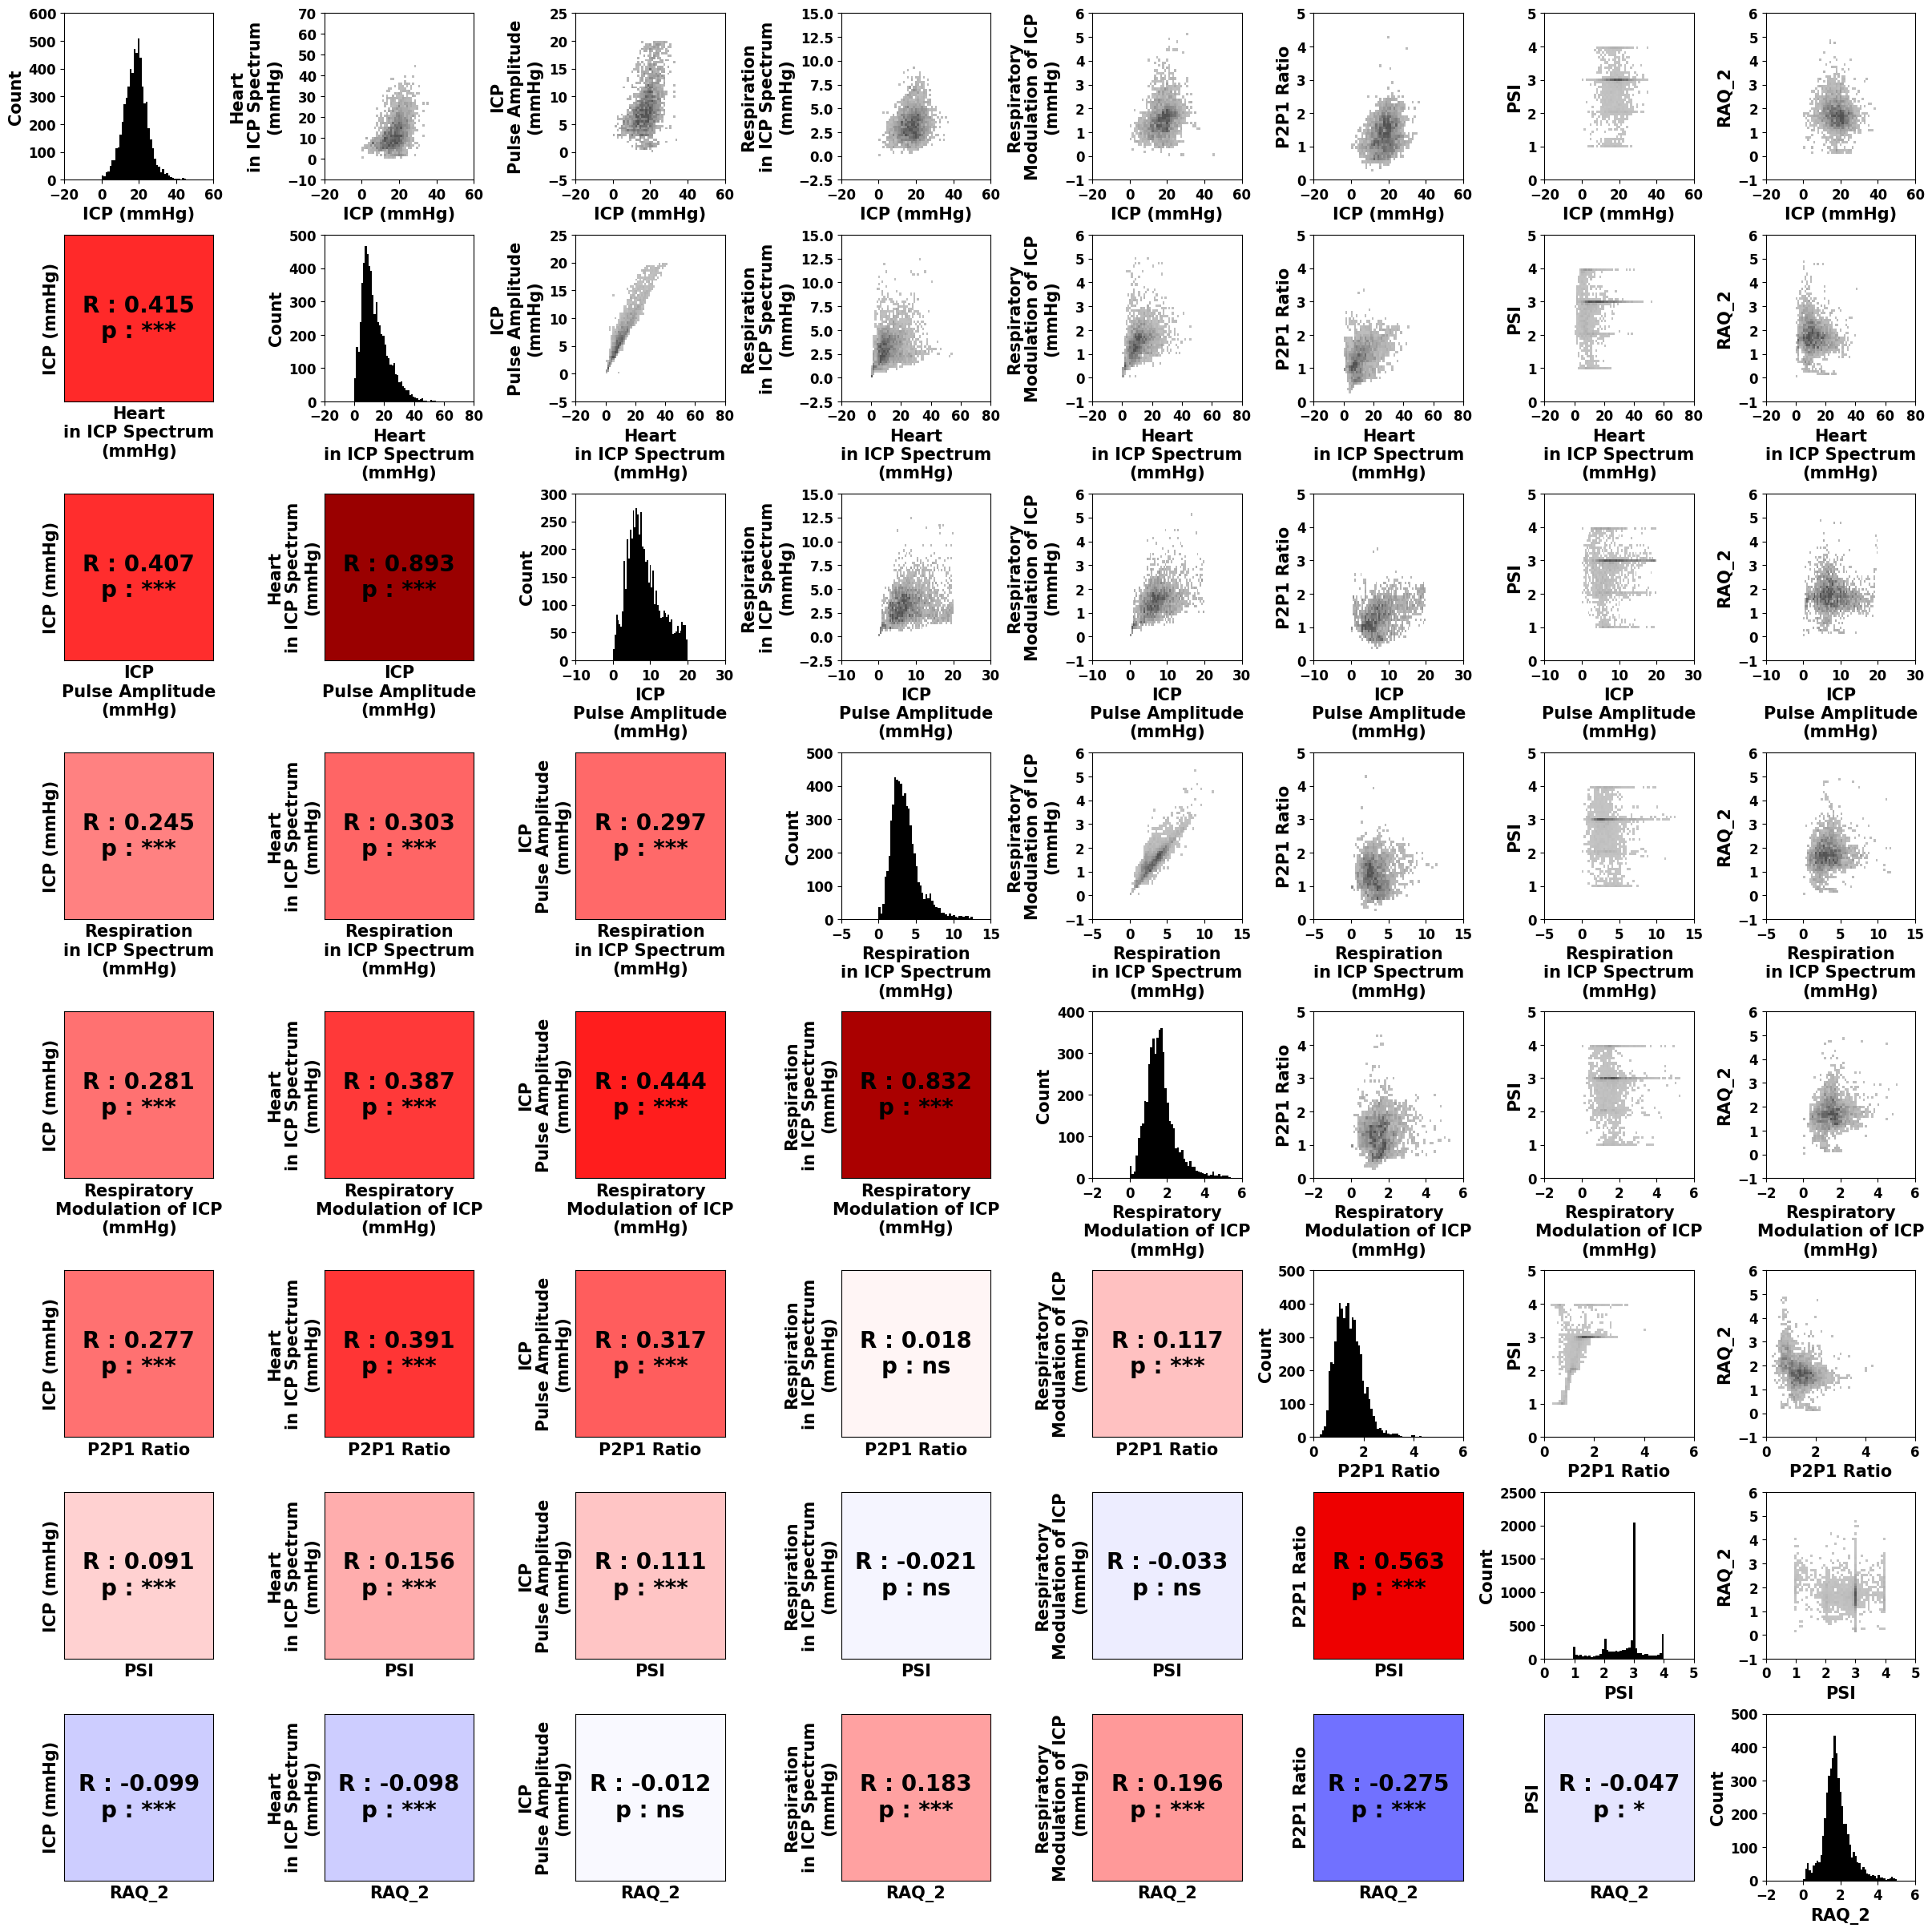

In [20]:
metrics = ['median_icp_mmHg',
 'heart_in_icp_spectrum',
 'icp_pulse_amplitude_mmHg',
 'resp_in_icp_spectrum',
 'icp_resp_modulated',
 'P2P1_ratio',
 'PSI',
 'RAQ_2',
 ]

# metrics = ['median_icp_mmHg',
#  'heart_in_icp_spectrum',
#  'icp_pulse_amplitude_mmHg',
#  'resp_in_icp_spectrum',
#  ]

print(len([i for i in itertools.combinations(metrics, 2)]))

p_labels = dict(
    fontsize = 15,
    weight = 'bold'
)
p_ticks = dict(
    weight = 'bold',
    fontsize = 12
)
pairplot_homemade(data_full[metrics], mapper_clean_name, savefile = save_folder / 'short_pairplot.png', p_labels=p_labels, p_ticks=p_ticks)
# pairplot_homemade(data_full[metrics], mapper_clean_name, savefile = None, p_labels=p_labels, p_ticks=p_ticks)

# Table computation requirements

In [5]:
file1 = base_folder / 'figures' / 'slow_icp_rises_figs' / 'resource_requirements' / 'res_requirements_samnode_v2.xlsx'
df1 = pd.read_excel(file1)
df1['Machine'] = 'High Power'

file2 = base_folder / 'figures' / 'slow_icp_rises_figs' / 'resource_requirements' / 'res_requirements_laptop_v4.xlsx'
df2 = pd.read_excel(file2)
df2['Machine'] = 'Low Power'

df = pd.concat([df1, df2]).reset_index(drop = True)

In [6]:
np.array(df['patient'].unique())

array(['P17', 'P71', 'P11', 'LJ8', 'P2', 'LA19', 'P41', 'SP2', 'P80',
       'P85', 'P69', 'P21', 'P37', 'P60', 'P83', 'P6', 'P4', 'P87', 'P90',
       'P39', 'P16', 'BM3', 'P86', 'NY15', 'P56', 'P43', 'P70', 'P64',
       'P42', 'P50', 'P67', 'MF12', 'P74', 'HA1', 'P65', 'P20', 'P73',
       'P76', 'P82', 'P32', 'P3', 'PL20', 'P96', 'P98', 'P79', 'P57',
       'FC13', 'P78', 'LD16', 'P81', 'P87_fin', 'BJ11', 'P12', 'P93',
       'P53', 'P40', 'P89', 'P63', 'NN7', 'GA9', 'P18_fin', 'P75', 'P27',
       'P77', 'P13', 'P68', 'P90_fin', 'P62', 'P14', 'JR10', 'WJ14',
       'P66', 'P84'], dtype=object)

In [7]:
df['metric'].unique()

array(['icp_heart_time_domain', 'icp_resp_time_domain',
       'icp_heart_and_resp_freq_domain', 'psi', 'P2P1_ratio'],
      dtype=object)

In [38]:
rename_metrics = {'icp_heart_and_resp_freq_domain':'Heart and Resp in ICP using Frequency-domain',
                    'icp_heart_time_domain':'Heart in ICP using time-domain', 
                  'icp_resp_time_domain':'Resp in ICP using time-domain',
                  'psi':'PSI', 
                  'P2P1_ratio':'P2P1 ratio'
                  }

metric_order = list(rename_metrics.values())
machine_order = ['High Power','Low Power']
order_rows = [(ma, me) for ma in machine_order for me in metric_order]

df['metric'].map(rename_metrics)

0                    Heart in ICP using time-domain
1                     Resp in ICP using time-domain
2      Heart and Resp in ICP using Frequency-domain
3                                               PSI
4                                        P2P1 ratio
                           ...                     
699                                      P2P1 ratio
700                  Heart in ICP using time-domain
701    Heart and Resp in ICP using Frequency-domain
702                                             PSI
703                                      P2P1 ratio
Name: metric, Length: 704, dtype: object

In [45]:
df['patient'].apply(lambda x:x.split('_')[0] if '_' in x else x).unique().size

71

In [ ]:
df['Metric'] = df['metric'].map(rename_metrics)
res_computers = df.groupby(['Machine','Metric'])[['duration_s','cpu','mem_MB']].max().round(2)
res_computers.columns = ['Duration (sec)','CPU (%)','Memory (GB)']
res_computers = res_computers.loc[order_rows,:]
# res_computers.to_excel(base_folder / 'figures' / 'slow_icp_rises_figs' / 'manuscript_compliance' / 'compute_ressources_max.xlsx')
#
res_computers

Duration (sec)  \
Machine    Metric                                                         
High Power Heart and Resp in ICP using Frequency-domain            0.06   
           Heart in ICP using time-domain                          0.15   
           Resp in ICP using time-domain                           0.16   
           PSI                                                     3.79   
           P2P1 ratio                                             16.74   
Low Power  Heart and Resp in ICP using Frequency-domain            0.21   
           Heart in ICP using time-domain                          0.28   
           Resp in ICP using time-domain                           0.28   
           PSI                                                     7.82   
           P2P1 ratio                                             17.00   

                                                         CPU (%)  Memory (GB)  
Machine    Metric                                                              
High Power Heart and Resp in ICP using Frequency-domain     69.8         7.09  
           Heart in ICP using time-domain                  119.8         2.63  
           Resp in ICP using time-domain                   119.7        12.98  
           PSI                                            4015.5      2391.43  
           P2P1 ratio                                      838.9       360.85  
Low Power  Heart and Resp in ICP using Frequency-domain     83.1         9.45  
           Heart in ICP using time-domain                  100.3        21.68  
           Resp in ICP using time-domain                   116.4        32.04  
           PSI                                             487.2      3917.89  
           P2P1 ratio                                      487.2      3627.34

# % Mobilisations vs events

In [ ]:
compliance_all = concat_slow_icp_features('compliance')

In [ ]:
compliance_all['Mobilisation']

In [ ]:
compliance_all.columns

In [ ]:
rows = []
count_events = 0
for p in compliance_all['patient'].unique():
    df_p = compliance_all[compliance_all['patient'] == p]
    for e in df_p['n_event'].unique():
        count_events += 1
        df_p_e = df_p[df_p['n_event'] == e]
        d = {'patient_file':p, 'patient':p if not '_' in p else p.split('_')[0], 'event':e, 'patient_event':f'{p}_{e}', 'n_cumulated_event':count_events, 'has_mobilisation':1 if 1 in df_p_e['Mobilisation'].unique() else 0}
        rows.append(d)
res = pd.DataFrame(rows)

In [ ]:
res

In [ ]:
res['patient'].unique().size

In [ ]:
res['has_mobilisation'].value_counts(normalize = True).round(2)

# Figure 4 : ICP waveform evolution

In [15]:
def summary_view(compliance_all, sub, i_event, win_label, n_minutes_study, mapper_clean_name, metrics_bars = ['median_icp_mmHg','heart_in_icp_spectrum','P2P1_ratio'], estimators = 'robust', suptitle_kind = None, letter = None, save = False, **p):
    win_size_s = p['win_size_s']
    ind_colnames = ['patient','n_event','win_label']

    p_title = {'fontsize':15, 'weight':'bold'}
    p_labels = {'fontsize':13, 'weight':'bold'}
    p_ticks = {'fontsize':11, 'weight':'bold'}

    cns_reader = pycns.CnsReader(data_path / sub)
    icp_stream = cns_reader.streams['ICP']
    raw_icp, datetimes = icp_stream.get_data(with_times = True, apply_gain = True)
    srate = icp_stream.sample_rate
    window_size_ind = int(srate * win_size_s)
    half_window_size_ind = window_size_ind // 2

    compliance_df_sub = compliance_all[compliance_all['patient'] == sub].reset_index(drop = True)
    event_nums = compliance_df_sub['n_event'].unique().tolist()
    assert i_event in event_nums, f'Event n°{i_event} does not exist (possible events = {event_nums})'
    icp_detections = detect_icp_job.get(sub).to_dataframe()

    dims = ['estimator','time']
    data_init = np.zeros((2, window_size_ind))
    t_vector = range(window_size_ind)/srate
    t_vector = t_vector - np.max(t_vector) / 2
    coords = {'estimator':['m','s'], 'time':t_vector}
    waveforms = xr.DataArray(data = data_init, dims = dims, coords = coords)

    compliance_df_ev = compliance_df_sub[compliance_df_sub['n_event'] == i_event].set_index('win_label')
    d1 = compliance_df_ev.loc[win_label, 'start_win_date']
    d2 = compliance_df_ev.loc[win_label, 'stop_win_date']
    local_icp_detections = icp_detections[(icp_detections['peak_date'] > (d2 - np.timedelta64(n_minutes_study, 'm'))) & (icp_detections['peak_date'] < d2)].reset_index(drop = True)
    n_icp_pulses = local_icp_detections.shape[0]
    epochs = np.zeros((local_icp_detections.shape[0], window_size_ind))
    for i, row in local_icp_detections.iterrows():
        peak_ind = row['peak_ind']
        start_ind = peak_ind - half_window_size_ind
        stop_ind = start_ind + window_size_ind
        icp_epoch = raw_icp[start_ind:stop_ind]
        epochs[i,:] = icp_epoch
    if estimators == 'robust':
        m = np.median(epochs, axis = 0)
        s = scipy.stats.median_abs_deviation(epochs, axis = 0, scale = 'normal')
    elif estimators == 'classic':
        m = np.mean(epochs, axis = 0)
        s = np.std(epochs, axis = 0)
    waveforms.loc['m',:] = m
    waveforms.loc['s',:] = s
    waveforms.attrs['n_icp_pulses'] = n_icp_pulses

    t = waveforms['time'].values

    ncols = 2
    fig, axs = plt.subplots(ncols = ncols, figsize = p['figsize'])
    if not suptitle_kind is None:
        if suptitle_kind == 'bad':
            suptitle = 'High ICP - Low Compliance'
            color_suptitle = 'r'
        elif suptitle_kind == 'good':
            suptitle = 'Low ICP - High Compliance'
            color_suptitle = 'g'
        fig.suptitle(suptitle, y = 1.1, weight = 'bold', fontsize = p['suptitle_fontsize'], color = color_suptitle)

    ax = axs[0]
    m = waveforms.loc['m',:].values
    s = waveforms.loc['s',:].values
    ax.plot(t, m, color = 'k', lw = 2, label = 'Median' if estimators == 'robust' else 'Mean')
    ax.fill_between(t, m-s, m+s, color = 'k', alpha = 0.2, label = '+/- MAD' if estimators == 'robust' else '+/- STD')
    ax.set_ylim(*p['ylim'])
    ax.set_xlim(t[0],t[-1])
    ax.set_ylabel(f'ICP (mmHg)', **p_labels)
    ax.set_xlabel('Time (s)', **p_labels)
    ax.set_yticks(ax.get_yticks()[1:-1], ax.get_yticklabels()[1:-1], **p_ticks)
    ax.set_xticks(ax.get_xticks()[1:-1], ax.get_xticklabels()[1:-1], **p_ticks)
    ax.set_title(f'Average ICP waveform (N={n_icp_pulses})', **p_title)
    ax.legend(loc = 'upper right', fontsize = 9)

    ax = axs[1]
    cmap = colormaps['RdYlGn_r'].resampled(100)
    xs =  []
    heights = []
    colors = []
    bar_labels = []
    xticklabels = []
    for x, metric in enumerate(metrics_bars):
        xs.append(x)
        value = compliance_all.set_index(ind_colnames).loc[(sub, i_event, win_label), metric]
        bar_labels.append(value)
        height = scipy.stats.percentileofscore(compliance_all[metric] , value, nan_policy='omit')
        heights.append(height)
        colors.append(cmap(height / 100))
        xticklabels.append(mapper_clean_name[metric])
    ax.bar(xs, heights, color=colors)
    ax.set_ylim(0, 104)
    ax.set_xticks(range(len(xticklabels)), xticklabels, rotation = 90, **p_ticks)
    ax.set_yticks(ax.get_yticks()[:-1], ax.get_yticklabels()[:-1], **p_ticks)
    ax.set_title('ICP features', **p_title)
    ax.set_ylabel('Percentile among all data', **p_labels)
    for i in range(len(metrics_bars)):
        ax.text(xs[i], heights[i], round(bar_labels[i], 2), ha = 'center', va = 'bottom')

    if not letter is None:
        ax.text(-0.1, 1.3, letter, transform=axs[0].transAxes, fontsize=p['suptitle_fontsize'], fontweight='bold', va='top', ha='right')

    if save:
        fig.savefig(base_folder / 'figures' / 'slow_icp_rises_figs' / 'manuscript_compliance' / 'fig4' / f'{sub}_{i_event}_{win_label}.png', bbox_inches = 'tight', dpi = 1000)
    plt.show()
    return fig

In [16]:
from PIL import Image

def merge_high_res_images(image_paths, output_path, dpi=1000):
    """
    Merges multiple high-resolution images into a single image, stacking them vertically.
    
    Parameters:
    - image_paths: List of file paths to the images to be merged.
    - output_path: Path to save the merged image.
    - dpi: DPI to be maintained for the merged image. Default is 1000.
    
    Returns:
    - None (saves the merged image at output_path)
    """
    # Open all images
    images = [Image.open(img_path) for img_path in image_paths]

    # Assuming all images have the same width
    width, height = images[0].size

    # Create a new blank image with height equal to the sum of all image heights
    merged_height = height * len(images)
    merged_img = Image.new("RGB", (width, merged_height), (255, 255, 255))

    # Paste all images into the new image (vertically stacked)
    for idx, img in enumerate(images):
        merged_img.paste(img, (0, idx * height))

    # Save the merged image with high DPI
    merged_img.save(output_path, dpi=(dpi, dpi))
    print(f"Image saved at {output_path} with DPI={dpi}")

In [18]:

mapper_clean_name = {
    "median_icp_mmHg" : "ICP (mmHg)",
    "heart_in_icp_spectrum" : "Heart\nin ICP Spectrum\n(mmHg)",
    "icp_pulse_amplitude_mmHg" : "ICP\nPulse Amplitude\n(mmHg)",
    "resp_in_icp_spectrum" : "Respiration\nin ICP Spectrum\n(mmHg)",
    "icp_resp_modulated" : "Respiratory\nModulation of ICP\n(mmHg)",
    "ratio_heart_resp_in_icp_spectrum" : "Heart / Resp\nSpectral Ratio",
    "icp_pulse_resp_modulated" : "Respiratory\nModulation of\nICP Pulse Amplitude (mmHg)",
    "median_abp_mmHg" : "ABP (mmHg)",
    "median_cpp_mmHg" : "CPP (mmHg)",
    "abp_pulse_amplitude_mmHg" : "ABP\nPulse Amplitude (mmHg)",
    "abp_pulse_resp_modulated" : "Respiratory\nModulation of\nABP Pulse Amplitude (mmHg)",
    "abp_resp_modulated" : "Respiratory\nModulation\nof ABP (mmHg)",
    "RAQ_2" : "RAQ_2",
    "RAQ_ABP" : "RAQ_ABP",
    "P2P1_ratio" : "P2P1 Ratio",
    "PSI" : "PSI",
    "PRx" : "PRx",
    "heart_rate_bpm" : "Heart Rate (bpm)",
    "resp_rate_cpm" : "Respiratory Rate (cpm)"
}


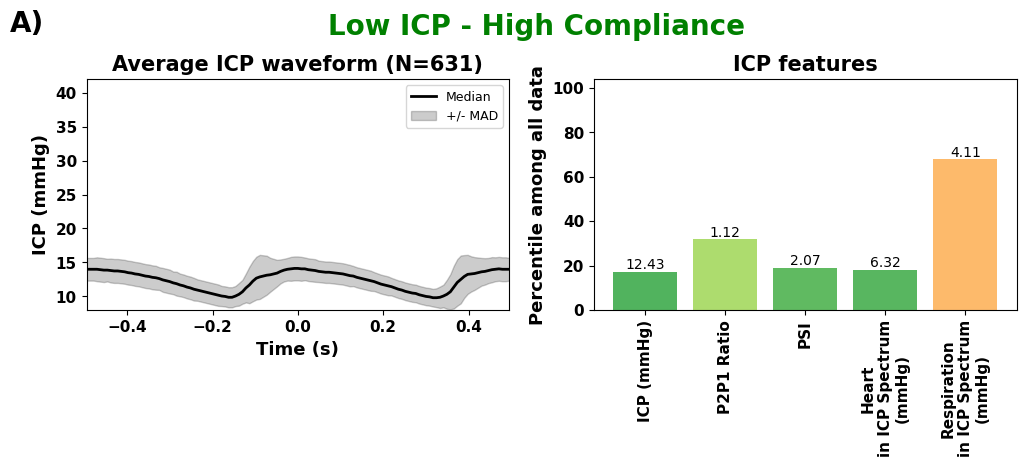

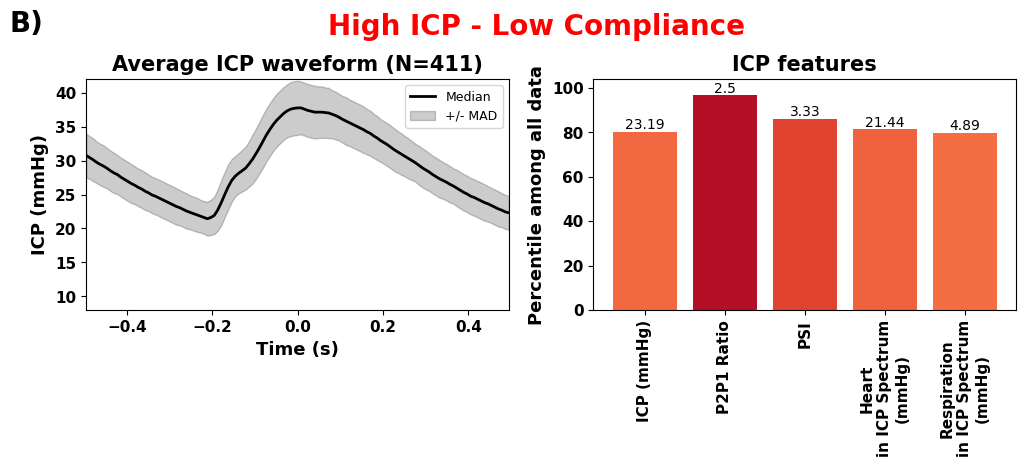

Image saved at /crnldata/tiger/baptiste.balanca/Neuro_rea_monitorage/figures/slow_icp_rises_figs/manuscript_compliance/fig4/fig4_python.png with DPI=1000


In [21]:
sub = 'FC13'
i = 2
win1 = 'baseline_before'
win2 = 'rise_5'

# metrics_bars = ['median_icp_mmHg','P2P1_ratio','PSI','RAQ_2','heart_in_icp_spectrum','resp_in_icp_spectrum']
metrics_bars = ['median_icp_mmHg','P2P1_ratio','PSI','heart_in_icp_spectrum','resp_in_icp_spectrum']
p = {
    'win_size_s' : 1.,
    'ylim':(8, 42),
    'figsize':(12, 3),
    'suptitle_fontsize':20,
}
n_minutes_study = 5
fig_A = summary_view(compliance_all=compliance_all, sub=sub, i_event=i , win_label=win1,  n_minutes_study=n_minutes_study, metrics_bars=metrics_bars, mapper_clean_name=mapper_clean_name, suptitle_kind='good', letter = 'A)', save = True, **p)
fig_B = summary_view(compliance_all=compliance_all, sub=sub, i_event=i , win_label=win2, n_minutes_study=n_minutes_study, mapper_clean_name=mapper_clean_name, metrics_bars=metrics_bars, suptitle_kind='bad', letter = 'B)', save = True,**p)

im1 = base_folder / 'figures' / 'slow_icp_rises_figs' / 'manuscript_compliance' / 'fig4' / f'{sub}_{i}_{win1}.png'
im2 = base_folder / 'figures' / 'slow_icp_rises_figs' / 'manuscript_compliance' / 'fig4' / f'{sub}_{i}_{win2}.png'
output_path = base_folder / 'figures' / 'slow_icp_rises_figs' / 'manuscript_compliance' / 'fig4' / 'fig4_python.png'
merge_high_res_images([im1, im2], output_path)

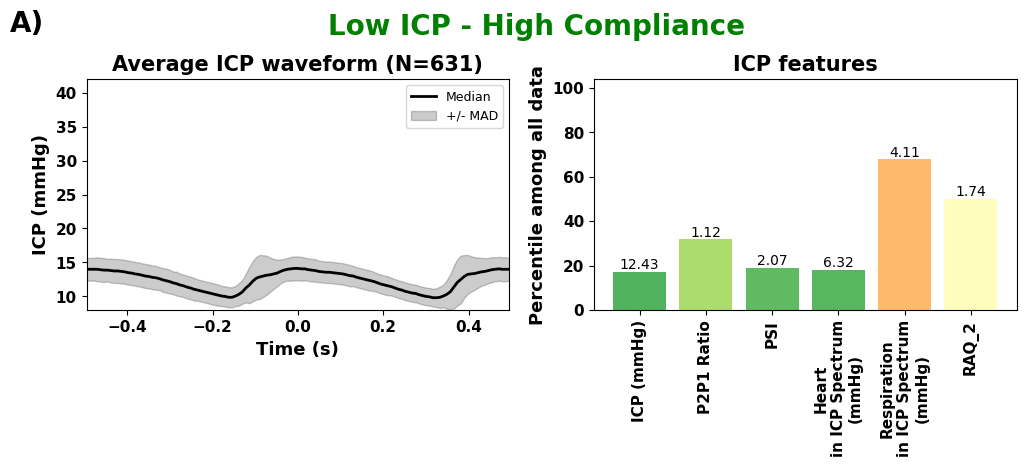

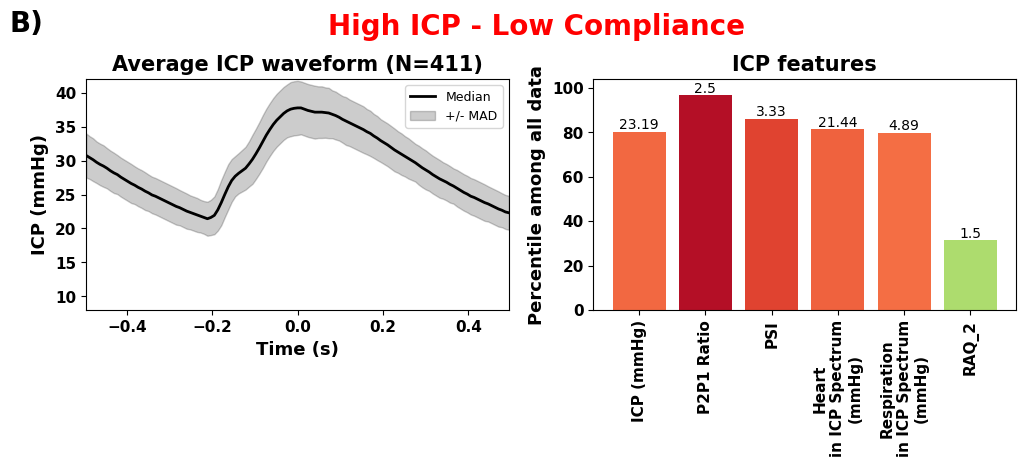

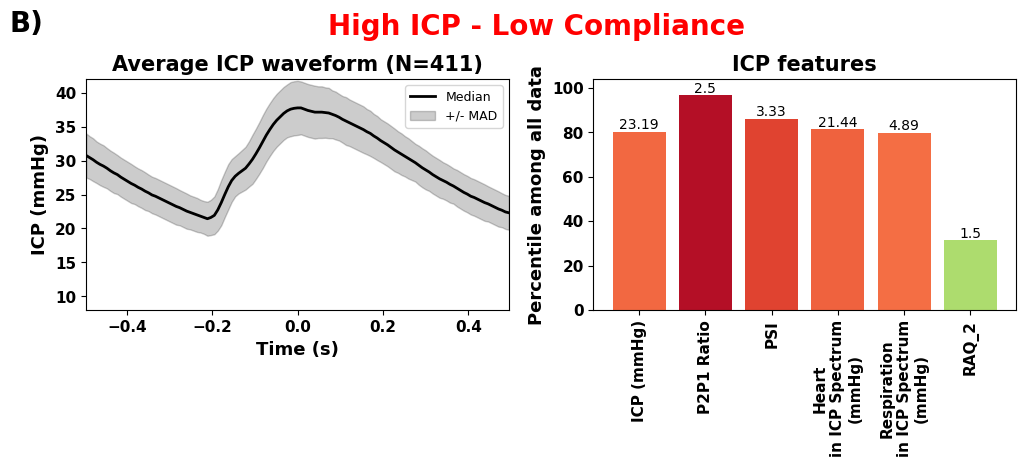

In [100]:
sub = 'FC13'
i = 2
win1 = 'baseline_before'
win2 = 'rise_5'

metrics_bars = ['median_icp_mmHg','P2P1_ratio','PSI','heart_in_icp_spectrum','resp_in_icp_spectrum','RAQ_2']
p = {
    'win_size_s' : 1.,
    'ylim':(8, 42),
    'figsize':(12, 3),
    'suptitle_fontsize':20,
}
n_minutes_study = 5
summary_view(compliance_all=compliance_all, sub=sub, i_event=i , win_label=win1,  n_minutes_study=n_minutes_study, metrics_bars=metrics_bars, mapper_clean_name=mapper_clean_name, suptitle_kind='good', letter = 'A)', save = False, **p)
summary_view(compliance_all=compliance_all, sub=sub, i_event=i , win_label=win2, n_minutes_study=n_minutes_study, mapper_clean_name=mapper_clean_name, metrics_bars=metrics_bars, suptitle_kind='bad', letter = 'B)', save = False,**p)


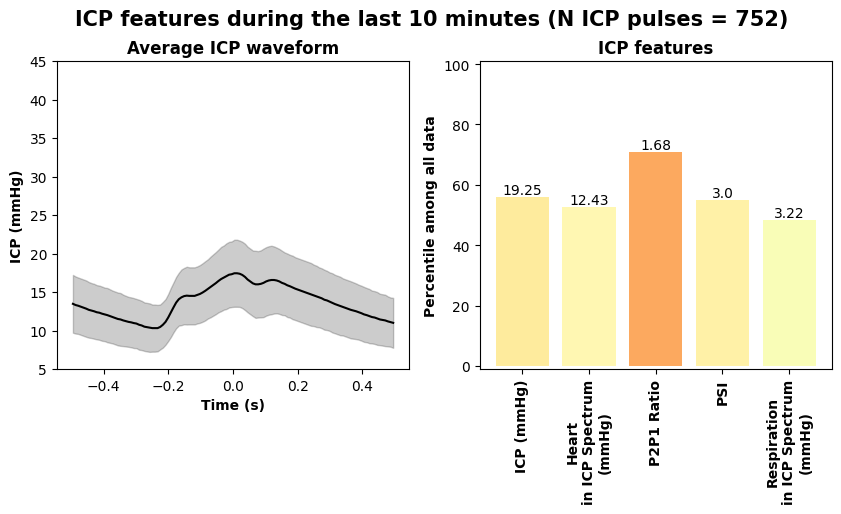

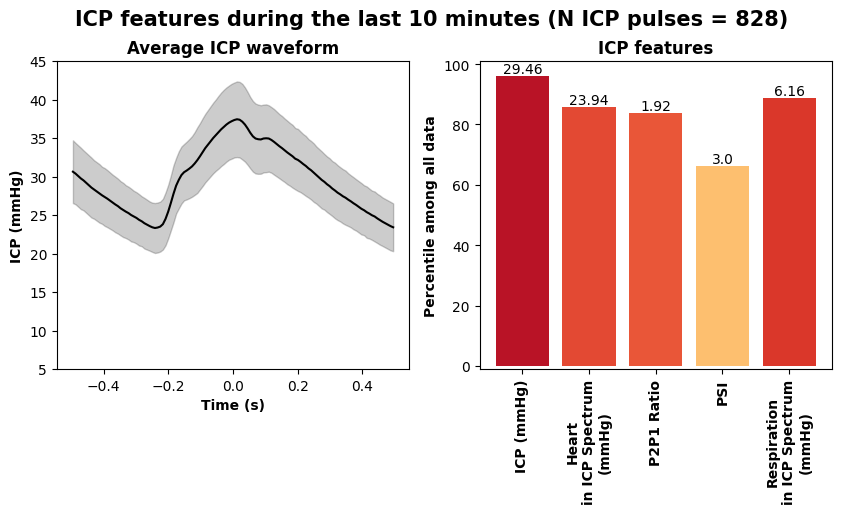

In [18]:
sub = 'JR10'
i = 2
win1 = 'baseline_before'
win2 = 'rise_5'
summary_view(compliance_all=compliance_all, sub=sub, i_event=i , win_label=win1,  n_minutes_study=n_minutes_study, metrics_bars=metrics_bars, mapper_clean_name=mapper_clean_name, **p)
summary_view(compliance_all=compliance_all, sub=sub, i_event=i , win_label=win2, n_minutes_study=n_minutes_study, mapper_clean_name=mapper_clean_name, metrics_bars=metrics_bars, **p)

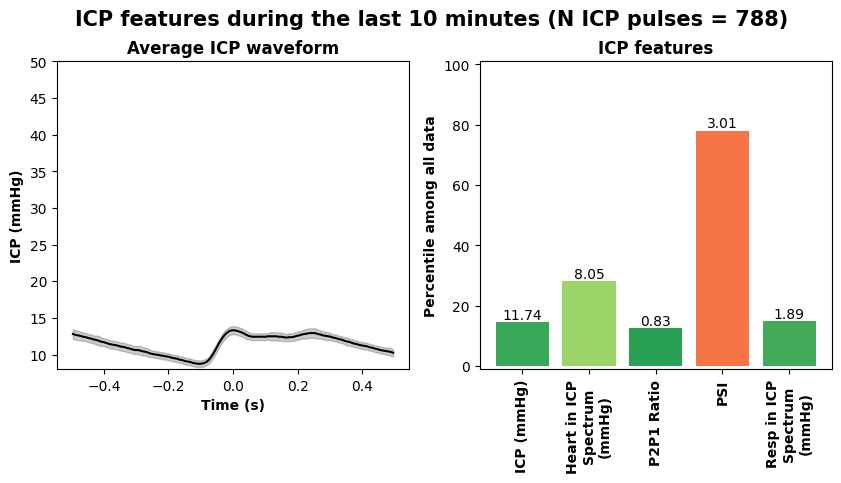

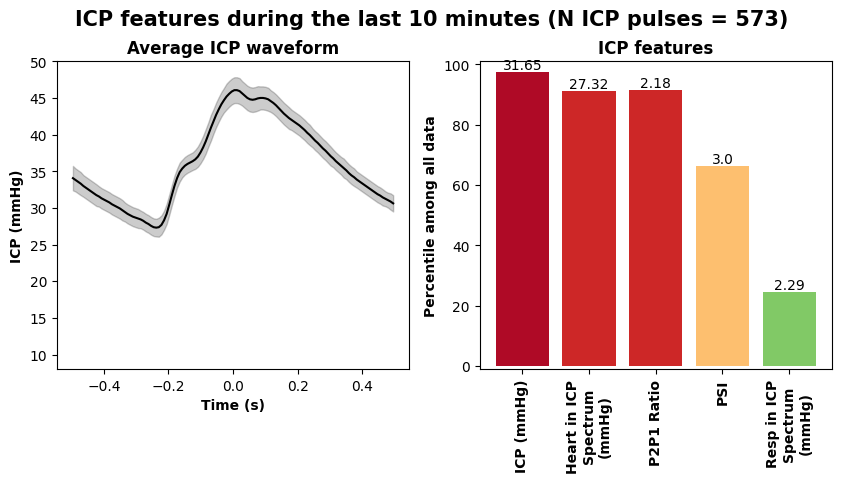

In [47]:
sub = 'P3'
i = 9
win1 = 'baseline_before'
win2 = 'rise_5'
p['ylim'] = (8, 50)
summary_view(compliance_all=compliance_all, sub=sub, i_event=i , win_label=win1,  n_minutes_study=n_minutes_study, metrics_bars=metrics_bars, mapper_clean_name=mapper_clean_name, save = True, **p)
summary_view(compliance_all=compliance_all, sub=sub, i_event=i , win_label=win2, n_minutes_study=n_minutes_study, mapper_clean_name=mapper_clean_name, metrics_bars=metrics_bars, save = True, **p)

In [41]:
res_norm[res_norm['P2P1_ratio'] > 100]

,patient,n_event,win_label,median_icp_mmHg,median_abp_mmHg,median_cpp_mmHg,heart_in_icp_spectrum,resp_in_icp_spectrum,ratio_heart_resp_in_icp_spectrum,icp_pulse_amplitude_mmHg,...,abp_pulse_amplitude_mmHg,abp_resp_modulated,abp_pulse_resp_modulated,P2P1_ratio,PSI,PRx,RAQ_2,RAQ_ABP,heart_rate_bpm,resp_rate_cpm
281,P3,1.0,rise_5,849.501749,12.526317,-18.870344,227.161402,450.616761,-48.859534,225.373134,...,8.981612,109.747405,26.553929,136.762448,-4.380778,573.880018,16.221127,76.437153,-14.321538,2.159025e+01
282,P3,1.0,decay_1,870.155315,8.868838,-23.439781,252.110152,958.008445,-65.694180,332.835821,...,2.545969,202.229685,58.031604,136.797973,-0.773023,493.682927,55.505683,79.570846,-20.327118,2.478066e+01
293,P3,2.0,rise_5,107.208622,16.385493,2.277752,186.985793,92.185513,36.089456,152.884615,...,19.435976,30.891393,118.725737,114.876142,6.666684,922.778492,-36.534299,-40.895816,-12.652060,1.061947e+01
294,P3,2.0,decay_1,107.838485,21.104045,7.631408,177.210294,43.102634,69.493695,172.115385,...,25.990854,41.075808,104.207031,112.086860,0.704046,791.550654,-42.004498,-35.571199,-6.510461,2.019231e+01
343,P3,6.0,decay_2,327.312609,44.296198,20.053521,319.630132,329.032282,5.790049,244.444444,...,71.160610,153.959542,96.517980,125.775947,-4.567771,71.110373,49.438773,21.295118,-9.213437,-2.000000e-01
376,P3,9.0,rise_4,108.692762,17.399282,0.478391,125.538636,3.866657,22.103762,214.473684,...,11.710037,13.114354,12.034568,136.132878,-1.358476,567.485789,-65.896633,-27.809417,-9.999988,1.869159e-01
377,P3,9.0,rise_5,169.624590,28.062593,1.824629,239.375180,21.513924,181.316565,285.526316,...,13.382900,13.520224,-5.615068,161.553661,-0.172941,777.588548,-18.003036,15.116467,-12.500000,5.628518e-01
378,P3,9.0,decay_1,176.133549,30.752460,3.806641,229.483847,65.348040,93.050706,277.631579,...,14.033457,56.977541,9.019625,155.284466,-0.172941,457.064259,-22.609267,28.332664,-10.638210,1.323251e+00
929,P11,9.0,rise_5,135.572271,4.924506,-10.925070,202.698020,121.159055,41.349345,169.135802,...,-6.921087,137.411861,120.487853,108.904339,30.283882,-101.757913,-1.628451,7.115263,-15.467686,-1.538462e+01
930,P11,9.0,decay_1,141.585216,7.225568,-9.074316,289.573951,128.116557,56.982893,256.790123,...,0.840880,165.550030,165.202460,162.256065,30.134111,-36.252302,49.590129,-8.235466,-15.009074,-1.538462e+01
